# MiniProject 1: Storage capacity in biologically plausible Hopfield networks #

## Introduction ##

The Hopfield model is a standard model in computational neuroscience that models the storage of memory items, in the form of “patterns” of neuronal activity, in the recurrent connectivity of a neural network.

The aim of this project is to investigate the robustness of memory retrieval in Hopfield networks with biologically plausible constraints. The lectures mostly covered standard Hopfield networks with balanced patterns and a symmetric weight matrix.

However, in biological networks, neural activity is generally sparse with only a few neurons active at a time.

Moreover, the symmetric connectivity of the standard Hopfield model is inconsistent with Dale’s law which states that the outgoing synapses from each neuron should be either excitatory or inhibitory; and it is very unlikely to find symmetric connectivity in the brain.

To address these issues, we will generalise the Hopfield model to low-activity patterns and separated excitatory and inhibitory populations. We will first start with a classic symmetric Hopfield network, and investigate the capacity of this network in storing balanced random patterns, i.e. with 50% of active neurons in the network.

In the second part, we will simulate a network with low-activity patterns. Finally, in the third section, we will separate the network into excitatory and inhibitory populations, and explore memory retrieval.

Note: the project is intended to be solved using Python without the need for any specific library (other than the usual numpy and matplotlib). You are free to use other libraries if you want

## Ex 0. Getting Started: Standard Hopfield Network ##

To get started, we first consider the classical Hopfield model with balanced random patterns, consisting of $N$ fully connected, continuously-valued nodes $S_i(t) \in [−1,\, 1]$. The $M$ memory patterns $P^{\mu} \in \{−1, 1\}^{N}$ where each component is either +1 or −1 with probability $\frac{1}{2}$, are stored in the network by the weight matrix given in the standard Hebbian form.

$$
W_{ij} = \frac{1}{N} \sum_{\mu = 1}^M P^{\mu}_i P^{\mu}_j
$$

At each time step, the states update according to the rule:

$$
S_i(t + 1) = \phi \Biggl( \sum_{j = 1}^N W_{ij} S_j(t) \Biggr)
$$

where $\phi(h) = \tanh(\beta h)$, and we use $\beta = 4$

## Ex 0.1 ##

Write a method that generates binary balanced random patterns; and a method that computes the next state $S(t + 1)$ of the network, given the current state $S(t) = (S_1(t), . . . , S_N(t))$ and a set of patterns $P^1, ..., P^M$ according to eqs.(1)-(2).

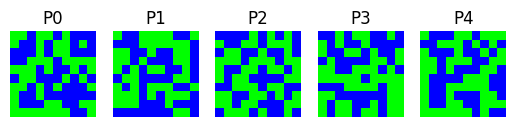

In [1]:
%matplotlib inline
from neurodynex3.hopfield_network import network, pattern_tools, plot_tools
from helper_functions import generate_random_patterns, custom_function
from matplotlib import pyplot as plt
import numpy as np

N = 100  # Number of neurons
M = 5    # Number of patterns
beta = 4 # The temperature

hopfield_net, factory, pattern_list = generate_random_patterns(M,N)
plot_tools.plot_pattern_list(pattern_list)

hopfield_net.set_dynamics_to_user_function(custom_function("phi", beta, N))

## Ex 0.2 ##

For a network with $N = 100$ neurons and $M = 5$ patterns, set the initial state close to the first pattern $P^1$.

To do this, randomly flip a given percentage c = 5% of neurons in the pattern.

Let the network evolve for 10-20 time steps until the network dynamics relax to a stable state.

Check the overlaps of the final state with all the patterns. Did the network correctly retrieve the first pattern?

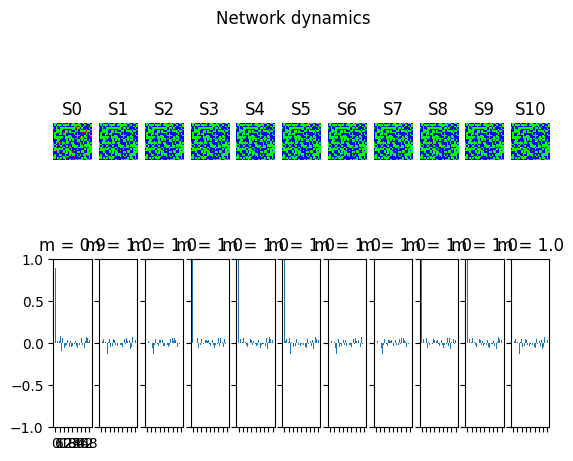

With 10 steps, the network did not converge to the stored pattern.
The overlap is 1.0


In [10]:
from helper_functions import study_overlap, flip_and_iterate

nr_steps = 10
c = 0.05

noisy_init_state, states, states_as_patterns = flip_and_iterate(hopfield_net, factory, pattern_list, int(c*N), nr_steps)
plot_tools.plot_state_sequence_and_overlap(states_as_patterns, pattern_list, reference_idx=0, suptitle="Network dynamics")

overlap = study_overlap(states_as_patterns, pattern_list, nr_steps)

## Ex 1. Storage capacity in the standard Hopfield network ##

In this first part, we simulate the standard Hopfield network defined above and numerically estimate its
storage capacity

### Ex 1.1 ###

Write a method that computes the next state $S(t + 1)$ of the network, given the current state $S(t)$, and a set of $M$ patterns $P^{\mu}$.

To do this, express the input to each neuron in terms of the M overlap variables $m^{\mu}(t) = \frac{1}{N} \sum_{i} P^{\mu}_i S_i(t)$:
$$
S_i(t+1) = \phi \Biggl( \sum_{j = 1}^N W_{ij} S_j(t) \Biggr) = \phi \Biggl( \sum_{j = 1}^N \biggl( \frac{1}{N} \sum_{\mu = 1}^M P^{\mu}_i P^{\mu}_j \biggr) S_j(t) \Biggr) = \phi \Biggl( \frac{1}{N} \sum_{\mu = 1}^M P^{\mu}_i \sum_{j = 1}^N P^{\mu}_j S_j(t) \Biggr) = \phi \Biggl( \frac{1}{N} \sum_{\mu = 1}^M P^{\mu}_i N \cdot \biggl( \frac{1}{N} \sum_{j = 1}^N P^{\mu}_j S_j(t) \biggr) \Biggr)
$$
$$
S_i(t+1) = \phi \Biggl( \frac{1}{N} \sum_{\mu = 1}^M P^{\mu}_i N \cdot m^{\mu}(t) \Biggr) = \phi \Biggl( N \cdot \frac{1}{N} \sum_{\mu = 1}^M P^{\mu}_i m^{\mu}(t) \Biggr) = \phi \Biggl( \sum_{\mu = 1}^M P^{\mu}_i m^{\mu}(t) \Biggr)
$$
This reduces the computational cost by avoiding the matrix multiplication $\sum_{j} W_{ij} \cdot S_j(t)$ at each time step.

What is the gain in the computational cost of a single update step?

The activation function $\phi(t)$ is computed using the _numpy_ library. Its computational complexity is considered of roughly $\mathcal{O}(N)$.

Multiplying the current state $S(t)$ of size $N \times 1$ by the weight matrix $W_{ij}$ of size $N \times N$ involves a computational cost of $\mathcal{O}(N^2)$.

The computational cost of the M overlap variables are of $\mathcal{O}(N)$ as both $\sum_{i}$ and $P^{\mu}_i \cdot S_i(t)$ involving one multiplication operation are of $\mathcal{O}(N)$. The summation over all M patterns has a cost of $\mathcal{O}(M)$. Although, computing M times $m^{\mu}(t)$ with a cost of $\mathcal{O}(N)$, implies a computational cost of $\mathcal{O}(M \cdot N)$ computing M times $m^{\mu}(t)$.

Therefore, as $M < N$ and in particular $M = 5$ and $N = 100$, the computational cost is reduced from $\mathcal{O}(N^2)$ to $\mathcal{O}(M \cdot N)$.

In [11]:
def phi_function_opti(state_s0, pattern_list):
    m_list = []
    for pattern in pattern_list:
        m_list.append((1/N) * np.sum(pattern * state_s0))
    h = np.sum(pattern_list * m_list, axis=0)
    state_s1 = np.tanh(beta * h)
    return state_s1

### Ex 1.2 ###

Write a method that computes the distance between two given patterns. In our case, we will use
the Hamming distance, defined as:
$$
D_{H}(P^{\mu}, P^{\nu}) = \frac{N − P^{\mu} \cdot P^{\nu}}{2N}
$$
What does this distance correspond to? What is the relationship with the overlap that we defined in the
lectures?

The Hamming distance as defined above, is a measure of similarity between two patterns $P^{\mu}$ and $P^{\nu}$. If the two patterns are equivalent, $P^{\mu} = P^{\nu}$, their Hamming distance is equal to 0. On the other hand, if they are totally different, their Hamming distance is equal to 1. For each neuron $i$, $P_i^{\mu} \cdot P_i^{\nu} = \{ +1$ if $P_i^{\mu} = P_i^{\nu}$ and $-1$ otherwise $\}$. Indeed, the Hamming distance gives a percentage of the different neurons from a pattern to another. The overlap function is also a measure of similarity. In the course, the correlation $C^{\mu, \nu}$ measures the overlap as in $m^{\mu}$, taking $P_i^{\nu}$ instead of $S_i(t)$:
$$
C^{\mu, \nu} = \frac{1}{N} \sum_{i = 1}^N P_i^{\mu} \cdot P_i^{\nu}
$$
The latter is related to the Hamming distance by:
$$
D_{H}(P^{\mu}, P^{\nu}) = \frac{N − P^{\mu} \cdot P^{\nu}}{2N} = \frac{1}{2} \Biggl( 1 - \frac{1}{N} \sum_{i = 1}^N P_i^{\mu} \cdot P_i^{\nu} \Biggr) = \frac{1}{2} (1 - C^{\mu, \nu})
$$

In [12]:
def hamming_distance(pattern1, pattern2):
    return (N-np.dot(pattern1.copy().flatten(), pattern2.copy().flatten()))/(2*N)

### Ex 1.3 ###

Create a Hopfield network with $N = 300$ neurons, in which $M = 5$ random patterns are stored.

Run the network for $T = 20$ steps after setting as the initial state the first of the random patterns with 15 of its bits flipped.

Plot the evolution of the Hamming distance between the network’s state $S(t)$ and each of the patterns $P^{\mu}$.

Was the first pattern retrieved correctly by the network?

Note: We say that the network has correctly retrieved the pattern $P^{\mu}$ if the last state $S(T)$ has a distance $D_H(P^{\mu}, S(T)) \le 0.05$.

Pattern retrieval: We call a set of M patterns $\{P^1, ..., P^M\}$ stored in the network a dictionary.

We define the error of pattern retrieval over a dictionary as:
$$
E = \frac{1}{M} \sum_{\mu = 1}^M D_H(P^{\mu}, S_f^{\mu})
$$
where $S_f^{\mu}$ is the final state of the network after convergence (you can use $T = 50$ iterations) if it was initialised close to pattern $P^{\mu}$
, i.e. with exactly 5% of its bits flipped.

Similarly, the number of retrieved patterns in a dictionary is the number of patterns $P^{\mu}$ in the dictionary such that $D_H(P^{\mu}, S_f^{\mu}) \le 0.05$.

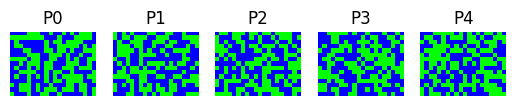

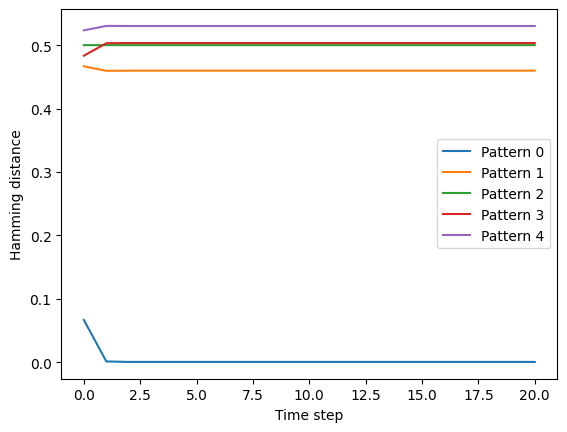

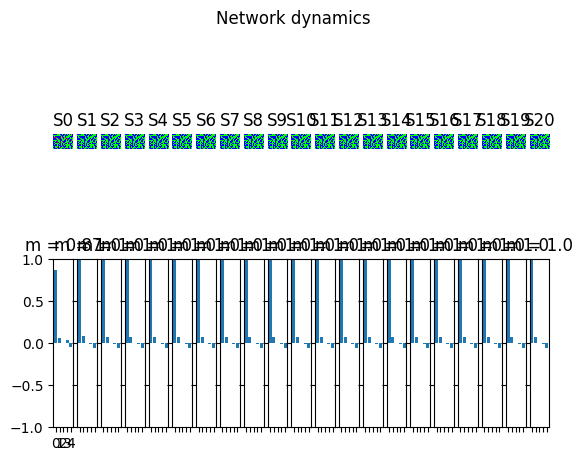

The pattern used to initialise the first state S(t=0) is P0.
The network retrieved the pattern P0.


In [13]:
from helper_functions import compute_hamming_distances, plot_hamming_distances, study_retrieval, all_same_pattern, custom_flip_and_iterate

N = 300       # Number of neurons
M = 5         # Number of patterns
beta = 4      # The temperature
T = 20        # Number of steps
nr_flips = 20 # Number of flips
T_f = 50      # Number of steps for the final state
c_f = 0.05    # The percentage of flipped bits for the final state
nr_flips_f = int(c_f*N)

hopfield_net, factory, pattern_list = generate_random_patterns(M,N)
plot_tools.plot_pattern_list(pattern_list)

noisy_init_pattern, states, states_as_patterns = custom_flip_and_iterate(factory, beta, N, nr_flips, T, pattern_list)

# Plot the hamming distances
hamming_distances = compute_hamming_distances(states_as_patterns, pattern_list, M, T, N)
plot_hamming_distances(hamming_distances, M, T)

plot_tools.plot_state_sequence_and_overlap(states_as_patterns, pattern_list, reference_idx=0, suptitle="Network dynamics")
noisy_init_pattern, states, states_as_patterns = custom_flip_and_iterate(factory, beta, N, nr_flips, T_f, pattern_list)
hamming_distances = compute_hamming_distances(states_as_patterns, pattern_list, M, T_f, N)
retrieved_patterns = study_retrieval(hamming_distances, M, c_f, init_id=0)

### Ex 1.4 ###

For a dictionary of size $M = 5$, what are the mean and standard deviation (std) of the error of pattern retrieval, and of the number of retrieved patterns? To compute them, iterate over $10-15$ different initialisations of the dictionary.

In [14]:
from helper_functions import study_simple_retrieval

nr_iterations = 15 # Number of iterations

error_retrieval_list = []
nr_retrieved_patterns_list = []

hopfield_net, factory, pattern_list = generate_random_patterns(M,N)
for i in range(nr_iterations):
    retrieved_patterns = []
    hamming_distances = []

    for init_id in range(M):
        noisy_init_pattern, state, state_as_pattern = custom_flip_and_iterate(factory, beta, N, nr_flips, T_f, pattern_list, init_pattern=init_id, only_last_state=True)
        hamming_distance, init_id = study_simple_retrieval(state_as_pattern, pattern_list[init_id], init_id, N, c_f)
        if init_id is not None:
            retrieved_patterns.append(init_id)
        hamming_distances.append(hamming_distance)
    
    error_retrieval_list.append(1/M * np.sum(np.array(hamming_distances), axis=0))
    nr_retrieved_patterns_list.append(len(retrieved_patterns))

# Compute the mean and the standard deviation of the error retrieval:
mean_error_retrieval = np.mean(error_retrieval_list)
std_error_retrieval = np.std(error_retrieval_list)
mean_retrieved_patterns = np.mean(nr_retrieved_patterns_list)
std_retrieved_patterns = np.std(nr_retrieved_patterns_list)
print("Mean error retrieval: {}".format(mean_error_retrieval))
print("Standard deviation error retrieval: {}".format(std_error_retrieval))
print("Mean retrieved patterns: {}".format(mean_retrieved_patterns))
print("Standard deviation retrieved patterns: {}".format(std_retrieved_patterns))

The network correctly retrieved the initial pattern P0.
The hamming distance is 0.0005065560192890454.
The network correctly retrieved the initial pattern P1.
The hamming distance is 0.0004609035996610563.
The network correctly retrieved the initial pattern P2.
The hamming distance is 0.00040664388222836576.
The network correctly retrieved the initial pattern P3.
The hamming distance is 0.0003692023849667218.
The network correctly retrieved the initial pattern P4.
The hamming distance is 0.0004909227286006512.
The network correctly retrieved the initial pattern P0.
The hamming distance is 0.0005065560192890454.
The network correctly retrieved the initial pattern P1.
The hamming distance is 0.0004609035996610563.
The network correctly retrieved the initial pattern P2.
The hamming distance is 0.00040664388222836576.
The network correctly retrieved the initial pattern P3.
The hamming distance is 0.0003692023849667218.
The network correctly retrieved the initial pattern P4.
The hamming dis

### Ex 1.5 ###

Repeat the previous question for dictionary sizes $M$ varying from $5$ to $80-100$. Plot the error of
pattern retrieval and the number of retrieved patterns as a function of dictionary size. Use the standard
deviations to get error bars.

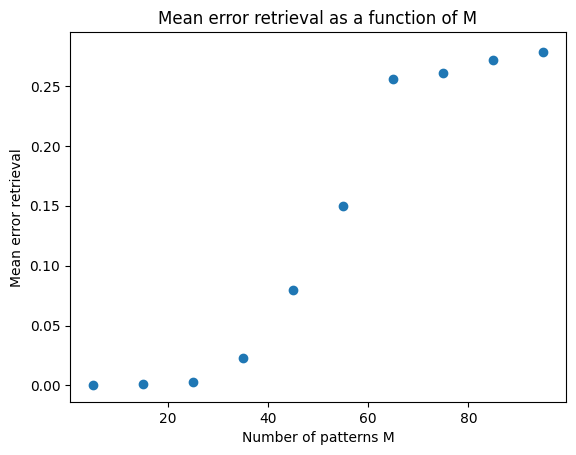

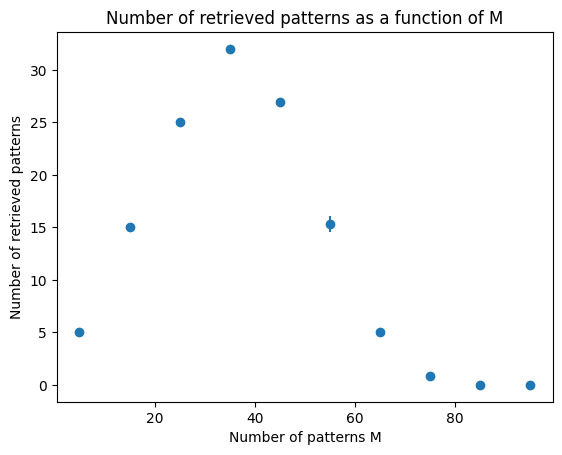

In [15]:
# A list of M values from 5 to 100 with a step of 5:
M_values = np.arange(5, 101, 10)
mean_error_retrieval_list = []
std_error_retrieval_list = []
mean_retrieved_patterns_list = []
std_retrieved_patterns_list = []
max_retrieved_patterns_list = {}

for M in M_values:
    nr_iterations = 15

    error_retrieval_list = []
    nr_retrieved_patterns_list = []

    hopfield_net, factory, pattern_list = generate_random_patterns(M,N)
    for i in range(nr_iterations):
        retrieved_patterns = []
        hamming_distances = []

        for init_id in range(M):
            noisy_init_pattern, state, state_as_pattern = custom_flip_and_iterate(factory, beta, N, nr_flips, T_f, pattern_list, init_pattern=init_id, only_last_state=True)
            hamming_distance, init_id = study_simple_retrieval(state_as_pattern, pattern_list[init_id], init_id, N, c_f, silent=True)
            if init_id is not None:
                retrieved_patterns.append(init_id)
            hamming_distances.append(hamming_distance)

        error_retrieval_list.append(1/M * np.sum(np.array(hamming_distances), axis=0))
        nr_retrieved_patterns_list.append(len(retrieved_patterns))
    
    mean_error_retrieval_list.append(np.mean(error_retrieval_list))
    std_error_retrieval_list.append(np.std(error_retrieval_list))
    mean_retrieved_patterns_list.append(np.mean(nr_retrieved_patterns_list))
    std_retrieved_patterns_list.append(np.std(nr_retrieved_patterns_list))
    max_retrieved_patterns_list[M] = np.amax(nr_retrieved_patterns_list)

# A plot of the mean error retrieval as a function of M with error bars using the standard deviation:
plt.errorbar(M_values, mean_error_retrieval_list, yerr=std_error_retrieval_list, fmt='o')
plt.xlabel("Number of patterns M")
plt.ylabel("Mean error retrieval")
plt.title("Mean error retrieval as a function of M")
plt.show()
plt.errorbar(M_values, mean_retrieved_patterns_list, yerr=std_retrieved_patterns_list, fmt='o')
plt.xlabel("Number of patterns M")
plt.ylabel("Number of retrieved patterns")
plt.title("Number of retrieved patterns as a function of M")
plt.show()

### Ex 1.6 - Attention questions théoriques!!! ###

What is the maximal number of patterns $M_{max}$ that can be stored and retrieved in the network?

Is it the maximum number of retrieved patterns value that can be read from the graph above?

No, it would be almost impossible that every randomly generated pattern is equivalent to $P^0$.

What happens to the retrieval error if the number of stored patterns increases beyond $M_{max}$? Why?
$$
E = \frac{1}{M} \Biggl( \sum_{\mu \neq \mu^{\star}} D_H(P^{\mu}, S_f^{\mu}) + \sum_{\mu = \mu^{\star}} \biggl( D_H(P^{\mu^{\star}}, S_f^{\mu^{\star}}) \leq 0.05 \biggr) \Biggr)
$$
If all patterns are the same and retrieved. $D_H(P^{\mu}, S_f^{\mu}) \leq 0.05 \; \forall \mu$. Therefore;
$$
E = \frac{1}{M} \sum_{\mu = i}^M \biggl( D_H(P^{\mu}, S_f^{\mu}) \leq 0.05 \biggr) \leq \frac{1}{M} M \cdot 0.05 \leq 0.05
$$

Capacity and loading: We call the ratio $L = \frac{M}{N}$ the _loading_ of the network; whereas the capacity of the network is defined as the ratio $C = \frac{M_{max}}{N}$ of the maximum number of patterns that can be retrieved in average in a dictionary, divided by the number of neurons.

In [16]:
M_max_th = N/(2*np.log(N))
# The maximum value of all items in the dictionary max_retrieved_patterns_list
M_max_exp = np.amax(list(max_retrieved_patterns_list.values()))
# The M value corresponding to the maximum value of all items in the dictionary max_retrieved_patterns_list
M_value = [key for key, value in max_retrieved_patterns_list.items() if value == M_max_exp][0]
capacity = M_max_exp/N
loading = M_value/N
print("Theoretical maximum number of patterns: {}".format(M_max_th))
print("Experimental maximum number of patterns: {}".format(M_max_exp))
print("Capacity: {}".format(capacity))
print("Loading: {}".format(loading))

Theoretical maximum number of patterns: 26.298338105721914
Experimental maximum number of patterns: 32
Capacity: 0.10666666666666667
Loading: 0.11666666666666667


### Ex 1.7 ###

For different network sizes $N$ from 50 to 800, plot the number of retrieved patterns per dictionary divided by $N$ as a function of the loading $L$.

How does the capacity depend on the network size? Is this what you would expect?

Hint: select a range of $4-5$ loadings $L = \frac{M}{N}$ close to the capacity you found for $N = 300$.

For each network size $N$ and loading $L$, compute the mean and std of the number of retrieved patterns across $5-10$ initialisations of the dictionary to get a plot (with the errorbars).

The capacity corresponds to the average number of retrieved patterns $M_{max}$ that you obtain for an optimal loading $L$, divided by $N$.

Computing capacity for N = 50...
Computing capacity for N = 100...
Computing capacity for N = 150...
Computing capacity for N = 200...
Computing capacity for N = 250...
Computing capacity for N = 300...
Computing capacity for N = 350...
Computing capacity for N = 400...
Computing capacity for N = 450...
Computing capacity for N = 500...
Computing capacity for N = 550...
Computing capacity for N = 600...
Computing capacity for N = 650...
Computing capacity for N = 700...
Computing capacity for N = 750...
Computing capacity for N = 800...


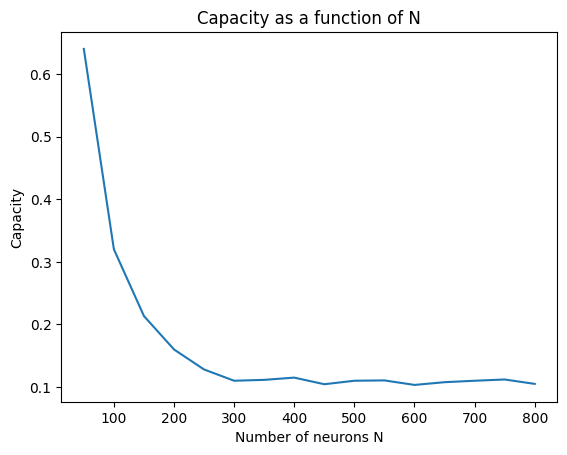

In [17]:
N_values = np.arange(50, 801, 50)
# The capacity found for N = 300
previous_capacity = capacity.copy()
retrieved_patterns_list = []
capacities = []

for N in N_values:
    print("Computing capacity for N = {}...".format(N))
    # M values are in a range of 5 values of M such that M/N is smaller than the capacity + c_f and M/N is larger than the capacity - c_f
    M_values = np.arange(int((previous_capacity - c_f) * N), int((previous_capacity + c_f) * N), int((2*c_f) * N / 5))

    for M in M_values:
        nr_iterations = 10

        nr_retrieved_patterns_list = []

        hopfield_net, factory, pattern_list = generate_random_patterns(M,N)
        for i in range(nr_iterations):
            retrieved_patterns = []
            hamming_distances = []

            for init_id in range(M):
                noisy_init_pattern, state, state_as_pattern = custom_flip_and_iterate(factory, beta, N, nr_flips, T_f, pattern_list, init_pattern=init_id, only_last_state=True)
                hamming_distance, init_id = study_simple_retrieval(state_as_pattern, pattern_list[init_id], init_id, N, c_f, silent=True)
                if init_id is not None:
                    retrieved_patterns.append(init_id)
                hamming_distances.append(hamming_distance)

            error_retrieval_list.append(1/M * np.sum(np.array(hamming_distances), axis=0))
            nr_retrieved_patterns_list.append(len(retrieved_patterns))

        mean_retrieved_patterns_list.append(np.mean(nr_retrieved_patterns_list))
        std_retrieved_patterns_list.append(np.std(nr_retrieved_patterns_list))
    
    capacities.append(np.amax(mean_retrieved_patterns_list)/N)

# A plot of the capacity as a function of N:
plt.figure()
plt.plot(N_values, capacities)
plt.xlabel("Number of neurons N")
plt.ylabel("Capacity")
plt.title("Capacity as a function of N")
plt.show()

### Ex 1.8 ###

How does the inverse temperature $\beta$ in eq.(2) affect the network capacity?

Computing capacity for beta = 0...
Computing capacity for beta = 1...
Computing capacity for beta = 2...
Computing capacity for beta = 3...
Computing capacity for beta = 4...
Computing capacity for beta = 5...
Computing capacity for beta = 6...
Computing capacity for beta = 7...
Computing capacity for beta = 8...
Computing capacity for beta = 9...
Computing capacity for beta = 10...


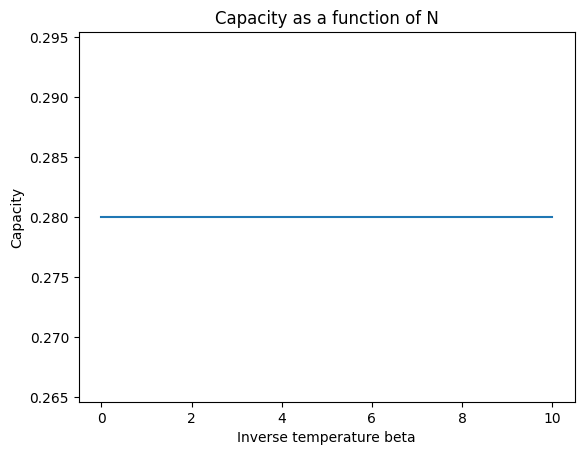

In [18]:
# Make an array of beta values from 0 to 10 with a step of 1
beta_list = np.arange(0, 11, 1)
# Take the number of neurons N = 300
N = 300
capacities = []

for beta in beta_list:
    print("Computing capacity for beta = {}...".format(beta))
    # M values are in a range of 5 values of M such that M/N is smaller than the capacity + c_f and M/N is larger than the capacity - c_f
    M_values = np.arange(int((previous_capacity - c_f) * N), int((previous_capacity + c_f) * N), int((2*c_f) * N / 5))

    for M in M_values:
        nr_iterations = 10

        nr_retrieved_patterns_list = []

        hopfield_net, factory, pattern_list = generate_random_patterns(M,N)
        for i in range(nr_iterations):
            retrieved_patterns = []
            hamming_distances = []

            for init_id in range(M):
                noisy_init_pattern, state, state_as_pattern = custom_flip_and_iterate(factory, beta, N, nr_flips, T_f, pattern_list, init_pattern=init_id, only_last_state=True)
                hamming_distance, init_id = study_simple_retrieval(state_as_pattern, pattern_list[init_id], init_id, N, c_f, silent=True)
                if init_id is not None:
                    retrieved_patterns.append(init_id)
                hamming_distances.append(hamming_distance)

            error_retrieval_list.append(1/M * np.sum(np.array(hamming_distances), axis=0))
            nr_retrieved_patterns_list.append(len(retrieved_patterns))

        mean_retrieved_patterns_list.append(np.mean(nr_retrieved_patterns_list))
        std_retrieved_patterns_list.append(np.std(nr_retrieved_patterns_list))

    capacities.append(np.amax(mean_retrieved_patterns_list)/N)

# A plot of the capacity as a function of beta:
plt.figure()
plt.plot(beta_list, capacities)
plt.xlabel("Inverse temperature beta")
plt.ylabel("Capacity")
plt.title("Capacity as a function of N")
plt.show()

## Ex 2. Low-activity patterns ##

We now study the capacity of a Hopfield network with stochastic binary neurons and low-activity patterns. This model is proposed in the paper by [Tsodyks and Feigel’man (1988)] and discussed briefly in Chapter 17.2.6 of the book Neuronal Dynamics.
Given a neuron’s continuous state $S_i(t) \in [−1,\, 1]$, we define the binary, stochastic spike variable $\sigma_i(t) \in \{0, 1\}$ as:

$$P\{ \sigma_i(t) = +1 \, | \, S_i(t) \} = \frac{1}{2}(S_i(t) + 1)$$

Where $\sigma_i = 1$ can be interpreted as a spike and $\sigma_i = 0$ as the quiescent state of the neuron. The states
update according to:

$$S_i(t + 1) = \phi \Biggl( \sum_{j = 1}^N w_{ij} \sigma_j(t) - \theta\Biggr)$$

Where the constant $\theta$ is the neuronal “firing threshold”. Synaptic weights are set according to:

$$w_{ij} = \frac{c}{N} \sum_{\mu = 1}^M (\xi_i^\mu - b)(\xi_j^\mu - a)$$

where $c = \frac{2}{{a(1-a)}}$, and a,b are constants in the [0, 1] interval. Here, each component $\xi_j^\mu\in \{0, 1\}$ in the patterns has a probability a of being 1, which is termed the activity or sparseness. Therefore, a represents the mean activity of the patterns.


### Ex 2.1 ###

For which values of the constants a, b, and $\theta$ is this model approximately equivalent to the standard Hopfield model in the previous section? Under which condition on the distribution of the patterns is it exactly equivalent (upon averaging over the stochastic update of eq.(5))?
Hint: write down and compare the average input to the neurons in both models.

Let $p_i^\mu = 2\xi_i^\mu - 1$. Then, 

$$w_{ij} = \frac{1}{N}\sum_{\mu = 1}^M p_i^\mu p_j^\mu = \frac{1}{N}\sum_{\mu = 1}^M (2\xi_i^\mu - 1) (2\xi_j^\mu - 1) = \frac{4}{N}\sum_{\mu = 1}^M (\xi_i^\mu - \frac{1}{2}) (\xi_j^\mu - \frac{1}{2})

Which shows that in order have an equivalence to the standard model, we need $a=b=\frac{1}{2}$. In order to find $\theta$, we use $\sigma_i(t) = \frac{1}{2}(S_i(t)+1)$.

$$S_i(t + 1) = \phi \Biggl( \sum_{j = 1}^N w_{ij} S_j(t) \Biggr) = \phi \Biggl( \sum_{j = 1}^N w_{ij} (2\sigma_j(t) - 1) \Biggr) = \phi \Biggl( \sum_{j = 1}^N \tilde{W}_{ij} \sigma_j(t) - \sum_{j = 1}^N w_{ij}\Biggr)$$


with $\theta = \sum_{j = 1}^N w_{ij}$ and $\tilde{W}_{ij} = 2w_{ij}\sigma_j$ to have an equilvalence to the standard model. 

If $<\xi_i^\mu> = a$, $<\sum_{j = 1}^N w_{ij}> = <\sum_{j = 1}^N \frac{c}{N}\sum_{\mu = 1}^M (\xi_i^\mu - b) (\xi_j^\mu - a)> = 0$

Therefore, $\theta = 0$. 

### Ex 2.2 ###

Write methods for generating random patterns $\xi^\mu\in \{0, 1\}^N$ with activity (i.e. average number of
(+1)’s) a, for computing the Hamming distance between new patterns $\xi^\mu$ and new state variables $\sigma$, and
for simulating the new model above.

First, we generate random patterns using activity a, the average number of (+1)'s, which can also be interpreted as the fraction of +1 in the pattern (since the two values of the pattern are 0 and 1). 

In [2]:
# just to reload helper_functions when needed
from importlib import reload
import helper_functions
reload(helper_functions)

<module 'helper_functions' from '/Users/sisi/Desktop/Neuronal Dynamics/Mini-project-NX-1/helper_functions.py'>

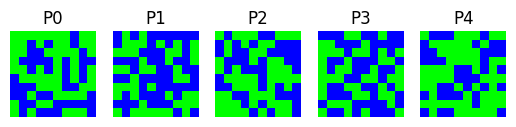

In [3]:
from neurodynex3.hopfield_network import plot_tools
from helper_functions import generate_random_patterns_low_activity, custom_function_low
import numpy as np

N = 100  # Number of neurons
M = 5    # Number of patterns
beta = 4 # The temperature
a = 0.5  # The activity level
b = 0.5

hopfield_net_low, pattern_list_low, shape = generate_random_patterns_low_activity(M,N,a,b)
plot_tools.plot_pattern_list(pattern_list_low)
teta = 0.0

hopfield_net_low.set_dynamics_to_user_function(custom_function_low("phi", beta, teta, a,b, N))

In [4]:
from helper_functions import compute_overlap_low

nr_steps = 10
c = 0.05

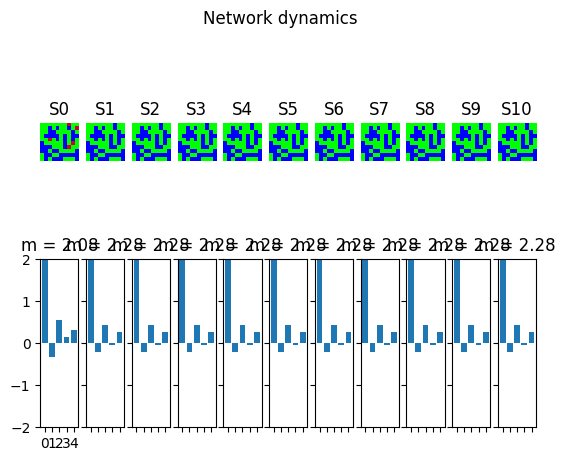

With 10 steps, the network did not converge to the stored pattern.
The overlap is 2.28


In [5]:
from helper_functions import study_overlap_low_activity, custom_flip_and_iterate_low, plot_state_sequence_and_overlap_low

noisy_init_state_low, states_low, states_as_patterns_low = custom_flip_and_iterate_low(shape, beta, teta, a, b, N, int(c*N), nr_steps, pattern_list_low, weights=hopfield_net_low.weights, function_name="phi")
plot_state_sequence_and_overlap_low(states_as_patterns_low, pattern_list_low, a, b, reference_idx=0, suptitle="Network dynamics")

overlap = study_overlap_low_activity(states_as_patterns_low, pattern_list_low, nr_steps, a)

In this case, the overlap is computed as:
$$
m^{\mu} = \frac{c}{N} \sum_{j = 1}^N (\xi_j^{\mu} - a) \sigma_j
$$
Where $\sigma_j \in \{ 0, 1 \} \forall j$, $\xi_j^{\mu} \forall j,\mu$, $a = 0.5$, $c = \frac{2}{a(1-a)} = 8$, and $N = 100$.
Therefore, one can compute $m^{\mu}_{min}$ and $m^{\mu}_{max}$:
$$
m^{\mu}_{min} = \frac{8}{100} \sum_{j = 1}^{100} (0 - 0.5) \cdot 0.5 = -2, \qquad m^{\mu}_{max} = \frac{8}{100} \sum_{j = 1}^{100} (1 - 0.5) \cdot 0.5 = 2
$$
And indeed, the obtained overlap lays in the theoretical interval ($m^{\mu} \in \left[ m^{\mu}_{min}, m^{\mu}_{max} \right] \forall \mu$).

Also, we can rewrite the expression of $S(t+1)$ using the overlap $m^{\mu}$:

$$S_i(t + 1) = \phi \Biggl( \sum_{j = 1}^N w_{ij} \sigma_j(t) - \theta \Biggr) = \phi \Biggl( \sum_{j = 1}^N  \frac{c}{N}\sum_{\mu = 1}^M (\xi_i^\mu - b) (\xi_j^\mu - a) \sigma_j(t) - \theta \Biggr) = \phi \Biggl( \sum_{\mu = 1}^M m_{\mu}(\xi_i^\mu - b)  - \theta \Biggr)$$

In [2]:
# just to reload helper_functions when needed
from importlib import reload
import helper_functions
reload(helper_functions)

<module 'helper_functions' from '/Users/sisi/Desktop/Neuronal Dynamics/Mini-project-NX-1/helper_functions.py'>

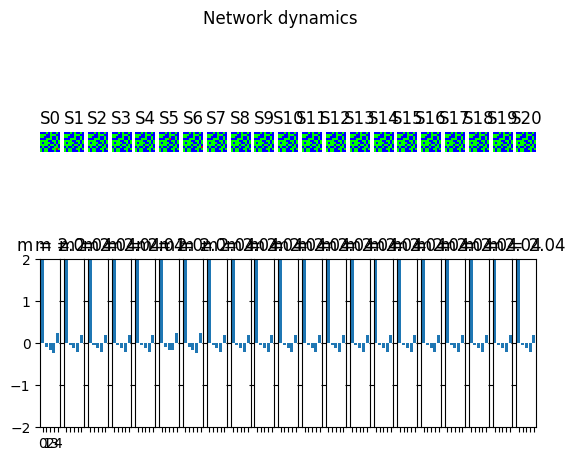

The pattern used to initialise the first state S(t=0) is P0.
The network retrieved the pattern P0.


In [6]:
from helper_functions import compute_hamming_distances_low, study_retrieval, all_same_pattern, custom_flip_and_iterate_low, plot_state_sequence_and_overlap_low

N = 100       # Number of neurons
M = 5         # Number of patterns
beta = 4      # The temperature
T = 20        # Number of steps
nr_flips = 1 # Number of flips
T_f = 50      # Number of steps for the final state
c_f = 0.05    # The percentage of flipped bits for the final state
nr_flips_f = int(c_f*N)

hopfield_net_low, pattern_list_low, shape = generate_random_patterns_low_activity(M,N,a,b)
noisy_init_pattern_low, states_low, states_as_patterns_low = custom_flip_and_iterate_low(shape, beta, teta, a, b, N, nr_flips, T, pattern_list_low)

plot_state_sequence_and_overlap_low(states_as_patterns_low, pattern_list_low, a, b, reference_idx=0, suptitle="Network dynamics")
noisy_init_pattern_low, states_low, states_as_patterns_low = custom_flip_and_iterate_low(shape, beta, teta, a, b, N, nr_flips, T_f, pattern_list_low, function_name= "phi_opti" )
hamming_distances_low = compute_hamming_distances_low(states_as_patterns_low, pattern_list_low, M, T_f, N)
retrieved_patterns_low = study_retrieval(hamming_distances_low, M, c_f, init_id=0)

### Ex 2.3 ###

Using the parameters $a,b, \theta$ that you found in question 2.1, compute the capacity of the network for N = 300. 
Is it the same as what you found in the previous section? If not, what you think is the origin of discrepancy?

In [7]:
from helper_functions import study_simple_retrieval_low, generate_random_patterns_low_activity

N = 300
a = 0.5
b = 0.5
M = 5
nr_iterations = 15 # Number of iterations

error_retrieval_list = []
nr_retrieved_patterns_list = []

hopfield_net_low, pattern_list_low, shape = generate_random_patterns_low_activity(M,N,a,b)

for i in range(nr_iterations):
    retrieved_patterns = []
    hamming_distances = []

    for init_id in range(M):
        noisy_init_pattern, state, state_as_pattern = custom_flip_and_iterate_low(shape, beta, teta, a, b, N, nr_flips, T_f, pattern_list_low, init_pattern=init_id, only_last_state=True)
        hamming_distance, init_id = study_simple_retrieval_low(state_as_pattern, pattern_list_low[init_id], init_id, N, c_f)
        if init_id is not None:
            retrieved_patterns.append(init_id)
        hamming_distances.append(hamming_distance)
    
    error_retrieval_list.append(1/M * np.sum(np.array(hamming_distances), axis=0))
    nr_retrieved_patterns_list.append(len(retrieved_patterns))

# Compute the mean and the standard deviation of the error retrieval:
mean_error_retrieval = np.mean(error_retrieval_list)
std_error_retrieval = np.std(error_retrieval_list)
mean_retrieved_patterns = np.mean(nr_retrieved_patterns_list)
std_retrieved_patterns = np.std(nr_retrieved_patterns_list)
print("Mean error retrieval: {}".format(mean_error_retrieval))
print("Standard deviation error retrieval: {}".format(std_error_retrieval))
print("Mean retrieved patterns: {}".format(mean_retrieved_patterns))
print("Standard deviation retrieved patterns: {}".format(std_retrieved_patterns))

The network correctly retrieved the initial pattern P0.
The hamming distance is 0.0.
The network correctly retrieved the initial pattern P1.
The hamming distance is 0.0.
The network correctly retrieved the initial pattern P2.
The hamming distance is 0.0033333333333333335.
The network correctly retrieved the initial pattern P3.
The hamming distance is 0.0.
The network correctly retrieved the initial pattern P4.
The hamming distance is 0.0.
The network correctly retrieved the initial pattern P0.
The hamming distance is 0.0.
The network correctly retrieved the initial pattern P1.
The hamming distance is 0.0.
The network correctly retrieved the initial pattern P2.
The hamming distance is 0.0.
The network correctly retrieved the initial pattern P3.
The hamming distance is 0.0.
The network correctly retrieved the initial pattern P4.
The hamming distance is 0.0.
The network correctly retrieved the initial pattern P0.
The hamming distance is 0.0.
The network correctly retrieved the initial pat

In [8]:
from helper_functions import study_simple_retrieval

# A list of M values from 5 to 100 with a step of 5:
M_values = np.arange(5, 101, 10)
N = 300
a = 0.5
b = 0.5

mean_error_retrieval_list = []
std_error_retrieval_list = []
mean_retrieved_patterns_list = []
std_retrieved_patterns_list = []
max_retrieved_patterns_list = {}

for M in M_values:
    nr_iterations = 5

    error_retrieval_list = []
    nr_retrieved_patterns_list = []

    hopfield_net_low, pattern_list_low, shape = generate_random_patterns_low_activity(M,N,a,b)

    for i in range(nr_iterations):
        retrieved_patterns = []
        hamming_distances = []

        for init_id in range(M): 
            noisy_init_pattern, state, state_as_pattern = custom_flip_and_iterate_low(shape, beta, teta , a, b, N, nr_flips, T_f, pattern_list_low, init_pattern=init_id, only_last_state=True)
            hamming_distance, init_id = study_simple_retrieval_low(state_as_pattern, pattern_list_low[init_id], init_id, N, c_f, silent=True)
            if init_id is not None:
                retrieved_patterns.append(init_id)
            hamming_distances.append(hamming_distance)

            error_retrieval_list.append(1/M * np.sum(np.array(hamming_distances), axis=0))

        nr_retrieved_patterns_list.append(len(retrieved_patterns))
    
    mean_error_retrieval_list.append(np.mean(error_retrieval_list))
    std_error_retrieval_list.append(np.std(error_retrieval_list))
    mean_retrieved_patterns_list.append(np.mean(nr_retrieved_patterns_list))
    std_retrieved_patterns_list.append(np.std(nr_retrieved_patterns_list))
    max_retrieved_patterns_list[M] = np.amax(nr_retrieved_patterns_list)
   

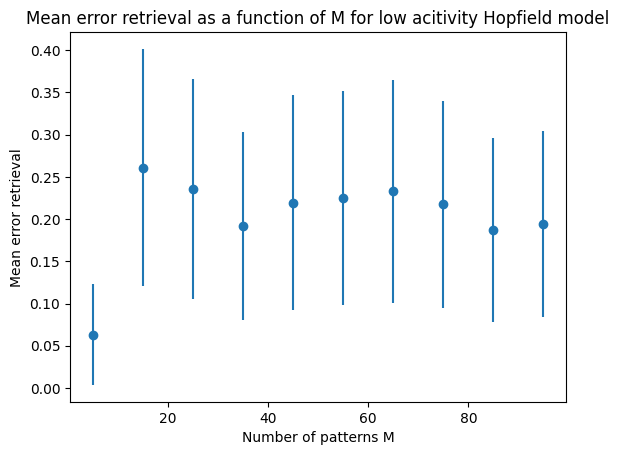

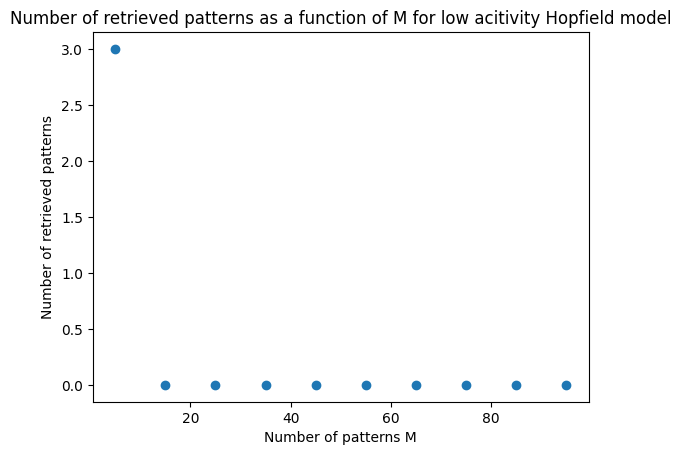

In [10]:
import matplotlib.pyplot as plt

# A plot of the mean error retrieval as a function of M with error bars using the standard deviation:
plt.errorbar(M_values, mean_error_retrieval_list, yerr=std_error_retrieval_list, fmt='o')
plt.xlabel("Number of patterns M")
plt.ylabel("Mean error retrieval")
plt.title("Mean error retrieval as a function of M for low acitivity Hopfield model")
plt.show()

plt.errorbar(M_values, mean_retrieved_patterns_list, yerr=std_retrieved_patterns_list, fmt='o')
plt.xlabel("Number of patterns M")
plt.ylabel("Number of retrieved patterns")
plt.title("Number of retrieved patterns as a function of M for low acitivity Hopfield model")
plt.show()


In [9]:
M_max_th = N/(2*np.log(N))
# The maximum value of all items in the dictionary max_retrieved_patterns_list
M_max_exp = np.amax(list(max_retrieved_patterns_list.values()))
# The M value corresponding to the maximum value of all items in the dictionary max_retrieved_patterns_list
M_value = [key for key, value in max_retrieved_patterns_list.items() if value == M_max_exp][0]
capacity = M_max_exp/N
loading = M_value/N
print("Theoretical maximum number of patterns: {}".format(M_max_th))
print("Experimental maximum number of patterns: {}".format(M_max_exp))
print("Capacity: {}".format(capacity))
print("Loading: {}".format(loading))

Theoretical maximum number of patterns: 26.298338105721914
Experimental maximum number of patterns: 9
Capacity: 0.03
Loading: 0.05


The capacity of the low activity model is lower than the standard Hopfield model. The pattern retrieval is significantly smaller, which is due to the fact that the synaptic weights are not as densely interlinked as the standard model. 
The use of a binomial distribution to update states adds stochasticity into the low activity model. 
The probabilistic update which leads to a higher variability in state transition could potentially destabilize the retrieval process (see custom_function and custom_function_low in helper_functions.py)

### Ex 2.4 ###
For $a = b = 0.5$, what value of the threshold $\theta$ corresponds to the best capacity? Plot the capacity as a function of $\theta$

In [45]:
# array of 5 values from -1 to 1 
theta_list = np.linspace(-1, 9, 10)

In [46]:
# A list of M values from 5 to 100 with a step of 5:
M_values = np.arange(5, 80, 5)
N = 300
a = 0.5
b = 0.5

mean_error_retrieval_list = []
std_error_retrieval_list = []
mean_retrieved_patterns_list = []
std_retrieved_patterns_list = []
max_retrieved_patterns_list = {}
capacities = []

# for each list of thetas, compute the capacity and store it in the capacities list as well as the corresponding thetas
for thetas in theta_list:
    print("Computing capacity for thetas...")

    for M in M_values:
        nr_iterations = 5

        error_retrieval_list = []
        nr_retrieved_patterns_list = []

        hopfield_net_low, pattern_list_low, shape = generate_random_patterns_low_activity(M,N,a,b)

        for i in range(nr_iterations):
            retrieved_patterns = []
            hamming_distances = []

            for init_id in range(M): 
                noisy_init_pattern, state, state_as_pattern = custom_flip_and_iterate_low(shape, beta, thetas, a, b, N, nr_flips, T_f, pattern_list_low, init_pattern=init_id, only_last_state=True)
                hamming_distance, init_id = study_simple_retrieval_low(state_as_pattern, pattern_list_low[init_id], init_id, N, c_f, silent=True)
                if init_id is not None:
                    retrieved_patterns.append(init_id)
                hamming_distances.append(hamming_distance)

            error_retrieval_list.append(1/M * np.sum(np.array(hamming_distances), axis=0))
            nr_retrieved_patterns_list.append(len(retrieved_patterns))
        
        mean_error_retrieval_list.append(np.mean(error_retrieval_list))
        std_error_retrieval_list.append(np.std(error_retrieval_list))
        mean_retrieved_patterns_list.append(np.mean(nr_retrieved_patterns_list))
        std_retrieved_patterns_list.append(np.std(nr_retrieved_patterns_list))
        max_retrieved_patterns_list[M] = np.amax(nr_retrieved_patterns_list)

    capacities.append(np.amax(list(max_retrieved_patterns_list.values()))/N)


Computing capacity for thetas...
Computing capacity for thetas...
Computing capacity for thetas...
Computing capacity for thetas...
Computing capacity for thetas...
Computing capacity for thetas...
Computing capacity for thetas...
Computing capacity for thetas...
Computing capacity for thetas...
Computing capacity for thetas...


Text(0.5, 1.0, 'Capacity as a function of theta for low activity Hopfield model with a=b=0.5')

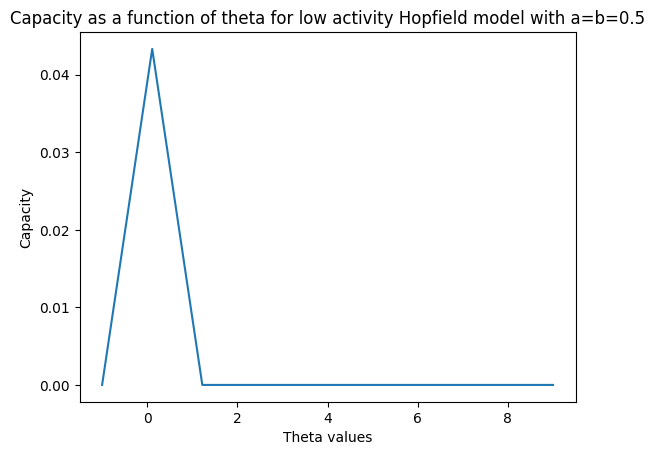

In [47]:
import matplotlib.pyplot as plt

plt.figure()
# have the values of theta on the x-axis and the capacities on the y-axis
plt.plot(theta_list, capacities)
plt.xlabel("Theta values")
plt.ylabel("Capacity")
plt.title("Capacity as a function of theta for low activity Hopfield model with a=b=0.5")

The threshold value for $\theta$ for the best capacity is 0.

### Ex 2.5 ###
Now, we go to the low-activity case. Repeat the previous question for $a = b = 0.1$ and $a = b = 0.05$.
What is the optimal value of $\theta$ in this case? Compare the capacity of the low-activity networks with that of the balanced network. 

In [48]:
# A list of M values from 5 to 100 with a step of 5:
M_values = np.arange(5, 80, 5)
N = 300
a = 0.1
b = 0.1 

mean_error_retrieval_list = []
std_error_retrieval_list = []
mean_retrieved_patterns_list = []
std_retrieved_patterns_list = []
max_retrieved_patterns_list = {}
capacities = []

# for each list of thetas, compute the capacity and store it in the capacities list as well as the corresponding thetas
for thetas in theta_list:
    print("Computing capacity for thetas...")

    for M in M_values:
        nr_iterations = 5

        error_retrieval_list = []
        nr_retrieved_patterns_list = []

        hopfield_net_low, pattern_list_low, shape = generate_random_patterns_low_activity(M,N,a,b)

        for i in range(nr_iterations):
            retrieved_patterns = []
            hamming_distances = []

            for init_id in range(M): 
                noisy_init_pattern, state, state_as_pattern = custom_flip_and_iterate_low(shape, beta, thetas, a, b, N, nr_flips, T_f, pattern_list_low, init_pattern=init_id, only_last_state=True)
                hamming_distance, init_id = study_simple_retrieval_low(state_as_pattern, pattern_list_low[init_id], init_id, N, c_f, silent=True)
                if init_id is not None:
                    retrieved_patterns.append(init_id)
                hamming_distances.append(hamming_distance)

            error_retrieval_list.append(1/M * np.sum(np.array(hamming_distances), axis=0))
            nr_retrieved_patterns_list.append(len(retrieved_patterns))
        
        mean_error_retrieval_list.append(np.mean(error_retrieval_list))
        std_error_retrieval_list.append(np.std(error_retrieval_list))
        mean_retrieved_patterns_list.append(np.mean(nr_retrieved_patterns_list))
        std_retrieved_patterns_list.append(np.std(nr_retrieved_patterns_list))
        max_retrieved_patterns_list[M] = np.amax(nr_retrieved_patterns_list)

    capacities.append(np.amax(list(max_retrieved_patterns_list.values()))/N)


Computing capacity for thetas...
Computing capacity for thetas...
Computing capacity for thetas...
Computing capacity for thetas...
Computing capacity for thetas...
Computing capacity for thetas...
Computing capacity for thetas...
Computing capacity for thetas...
Computing capacity for thetas...
Computing capacity for thetas...


Text(0.5, 1.0, 'Capacity as a function of theta for low activity Hopfield model with a=b=0.1')

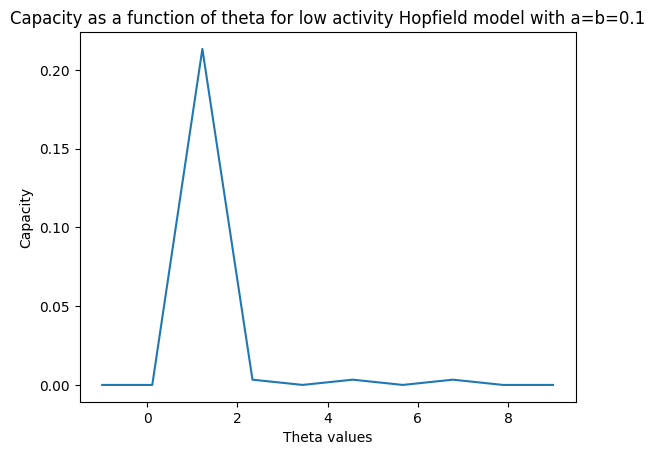

In [49]:
plt.figure()
# have the values of theta on the x-axis and the capacities on the y-axis with labels
plt.plot(theta_list, capacities)
plt.xlabel("Theta values")
plt.ylabel("Capacity")
plt.title("Capacity as a function of theta for low activity Hopfield model with a=b=0.1")

In [50]:
# A list of M values from 5 to 100 with a step of 5:
M_values = np.arange(5, 80, 10)
N = 300
a = 0.05
b = 0.05

mean_error_retrieval_list = []
std_error_retrieval_list = []
mean_retrieved_patterns_list = []
std_retrieved_patterns_list = []
max_retrieved_patterns_list = {}
capacities = []

# for each list of thetas, compute the capacity and store it in the capacities list as well as the corresponding thetas
for thetas in theta_list:
    print("Computing capacity for thetas...")

    for M in M_values:
        nr_iterations = 5

        error_retrieval_list = []
        nr_retrieved_patterns_list = []

        hopfield_net_low, pattern_list_low, shape = generate_random_patterns_low_activity(M,N,a,b)

        for i in range(nr_iterations):
            retrieved_patterns = []
            hamming_distances = []

            for init_id in range(M): 
                noisy_init_pattern, state, state_as_pattern = custom_flip_and_iterate_low(shape, beta, thetas, a, b, N, nr_flips, T_f, pattern_list_low, init_pattern=init_id, only_last_state=True)
                hamming_distance, init_id = study_simple_retrieval_low(state_as_pattern, pattern_list_low[init_id], init_id, N, c_f, silent=True)
                if init_id is not None:
                    retrieved_patterns.append(init_id)
                hamming_distances.append(hamming_distance)

            error_retrieval_list.append(1/M * np.sum(np.array(hamming_distances), axis=0))
            nr_retrieved_patterns_list.append(len(retrieved_patterns))
        
        mean_error_retrieval_list.append(np.mean(error_retrieval_list))
        std_error_retrieval_list.append(np.std(error_retrieval_list))
        mean_retrieved_patterns_list.append(np.mean(nr_retrieved_patterns_list))
        std_retrieved_patterns_list.append(np.std(nr_retrieved_patterns_list))
        max_retrieved_patterns_list[M] = np.amax(nr_retrieved_patterns_list)

    capacities.append(np.amax(list(max_retrieved_patterns_list.values()))/N)

Computing capacity for thetas...
Computing capacity for thetas...
Computing capacity for thetas...
Computing capacity for thetas...
Computing capacity for thetas...
Computing capacity for thetas...
Computing capacity for thetas...
Computing capacity for thetas...
Computing capacity for thetas...
Computing capacity for thetas...


[0.0, 0.0, 0.23333333333333334, 0.17333333333333334, 0.16333333333333333, 0.15333333333333332, 0.12666666666666668, 0.15, 0.13, 0.13333333333333333] [-1.          0.11111111  1.22222222  2.33333333  3.44444444  4.55555556
  5.66666667  6.77777778  7.88888889  9.        ]


Text(0.5, 1.0, 'Capacity as a function of theta for low activity Hopfield model with a=b=0.05')

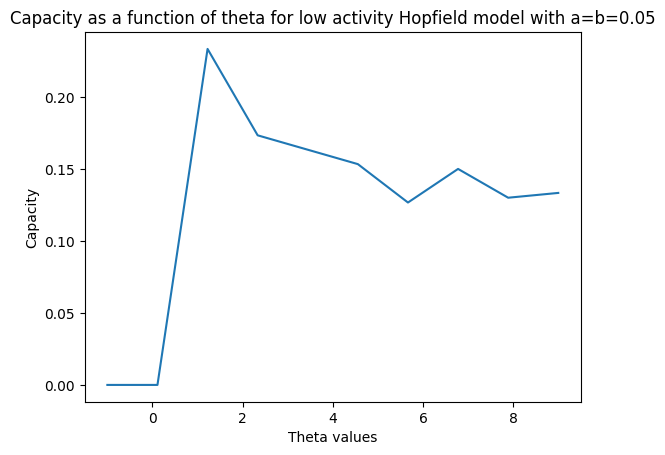

In [51]:
plt.figure()
# have the values of theta on the x-axis and the capacities on the y-axis
print(capacities, theta_list)
plt.plot(theta_list, capacities)
plt.xlabel("Theta values")
plt.ylabel("Capacity")
plt.title("Capacity as a function of theta for low activity Hopfield model with a=b=0.05")

In the case where $a=b=0.1$ and $a=b=0.05$, the $\theta$ threshold value is approx. $1.2$.

### 2.6

In the low-activity case $a=0.1$, try asymmetric connectivities by varying the value of $b$. Which combination of the parameters $b$ and $\theta$ gives you the best capacity?

In [ ]:
# let's try to see how the varying values of theta affect the capacity of the network for a = 0.1 and b varying from 0.05 to 0.5 with a step of 0.1.
b_values = np.arange(0.05, 0.50, 0.05)

# A list of M values from 5 to 100 with a step of 5:
M_values = np.arange(5, 80, 10)
N = 100
a = 0.1

mean_error_retrieval_list = []
std_error_retrieval_list = []
mean_retrieved_patterns_list = []
std_retrieved_patterns_list = []
max_retrieved_patterns_list = {}
capacities = {}

# for each list of thetas, compute the capacity using different values of b and store the pair of b and theta with the best capacity
for b in b_values:
    for thetas in theta_list:
        print("Computing capacity for thetas...")

        for M in M_values:
            nr_iterations = 5

            error_retrieval_list = []
            nr_retrieved_patterns_list = []

            hopfield_net_low, pattern_list_low, shape = generate_random_patterns_low_activity(M,N,a,b)

            for i in range(nr_iterations):
                retrieved_patterns = []
                hamming_distances = []

                for init_id in range(M): 
                    noisy_init_pattern, state, state_as_pattern = custom_flip_and_iterate_low(shape, beta, thetas, a, b, N, nr_flips, T_f, pattern_list_low, init_pattern=init_id, only_last_state=True)
                    hamming_distance, init_id = study_simple_retrieval_low(state_as_pattern, pattern_list_low[init_id], init_id, N, c_f, silent=True)
                    if init_id is not None:
                        retrieved_patterns.append(init_id)
                    hamming_distances.append(hamming_distance)

                error_retrieval_list.append(1/M * np.sum(np.array(hamming_distances), axis=0))
                nr_retrieved_patterns_list.append(len(retrieved_patterns))
            
            mean_error_retrieval_list.append(np.mean(error_retrieval_list))
            std_error_retrieval_list.append(np.std(error_retrieval_list))
            mean_retrieved_patterns_list.append(np.mean(nr_retrieved_patterns_list))
            std_retrieved_patterns_list.append(np.std(nr_retrieved_patterns_list))
            max_retrieved_patterns_list[M] = np.amax(nr_retrieved_patterns_list)

        capacities[(b, thetas)] = np.amax(list(max_retrieved_patterns_list.values()))/N



<Figure size 640x480 with 0 Axes>

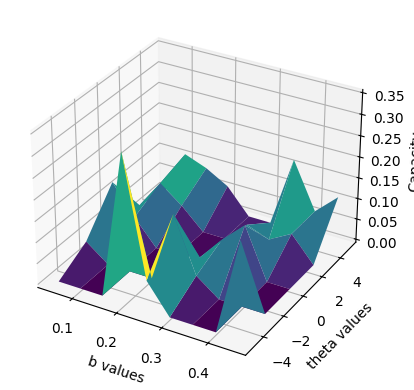

In [ ]:
# plot capacities as a function of b and theta pair
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
b_values = np.array(b_values)
theta_list = np.array(theta_list)
capacities = np.array(list(capacities))

b_unique = np.unique(b_values)
theta_unique = np.unique(theta_list)
B, Theta = np.meshgrid(b_unique, theta_unique)

# Reshape capacities if it corresponds to a 2D grid of 9x5
capacities = capacities.reshape((len(theta_unique), len(b_unique)))

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(B, Theta, capacities, cmap='viridis')

ax.set_xlabel('b values')
ax.set_ylabel('theta values')
ax.set_zlabel('Capacity')
plt.show()


## Ex 3. Separate inhibitory population ##

Let's study the capacity of a Hopfield network with stochastic binary neurons and low-activity patterns with the following model:
This model is proposed in the paper by [Tsodyks and Feigel’man (1988)] and discussed briefly in Chapter 17.2.6 of the book Neuronal Dynamics.
Given a neuron’s continuous state $S_i(t) = [-1, 1]$, we define the binary, stochastic spike variable $\sigma_i(t) = \{0, 1\}$ as: 
$$
P \{ \sigma_i(t) = +1 | S_i(t) \} = \frac{1}{2} (S_i(t) + 1)
$$
where $\sigma_i = 1$ can be interpreted as a spike and $\sigma_i = 0$ as the quiescent state of the neuron. The states update according to: 
$$
S_i(t + 1) = \phi \left( \sum_{j=1}^N w_{ij} \sigma_j(t) - \theta \right)
$$
where $\phi (h) = \text{tanh}(4h)$ and the constant $\theta$ is the neuronal "firing threshold". Synaptic weights are set according to: 
$$
w_{ij} = \frac{c}{N} \sum_{\mu = 1}^M (\xi_i^\mu - b) (\xi_j^\mu -a)
$$
where $c = \frac{2}{a(1-a)}$, and $a$, $b$ are constants in the $[0, 1]$ interval. Here, each component $\xi_i^{\mu} \in \{ 0, 1 \}$ of the patterns has a probability $a$ of being 1, which we call the activity (or sparseness). Therefore, $a$ is the mean activity of the patterns.

**Ex 3. Separate inhibitory population**

In a more biologically plausible model, the outgoing synapses from a given neuron cannot be both inhibitory and excitatory (that is, negative and positive): this is the Dale’s law, stating that each neuron should be either inhibitory or excitatory (with negative or positive outgoing weights). In this section, we see how a Hopfield network can include separate inhibitory and excitatory populations. We continue working with the same binary stochastic spike variables $\sigma_i(t)$, and with random patterns $\xi_i^{\mu} \in \{ 0, 1 \}$ with a mean activity of $a$. Patterns are stored in a population of excitatory neurons that receive negative feedback from an inhibitory population. The synaptic weight from excitatory neuron $j$ to excitatory neuron $i$ is given by: 
$$
W^{E \leftarrow E}_{ij} = \frac{c}{N} \sum_{\mu} \xi_i^{\mu} \xi_j^{\mu}
$$
The inhibitory population is composed of $N_I$ neurons. Each inhibitory neuron $k$ receives input from $\textbf{exactly}$ $K$ excitatory neurons, selected at random in the excitatory population, with synaptic strength 
$$
W^{I \leftarrow E}_{ki} = \frac{1}{K}
$$
Each excitatory neuron $i$ receives $\textit{negative}$ input from inhibitory neuron $k$ with weight: 
$$
W^{E \leftarrow I}_{ik} = \frac{ca}{N_I} \sum_{\mu} \xi_i^{\mu}
$$
Finally, we assume that inhibitory neurons have a linear gain function: their state is a stochastic spike variable $\sigma_k^I \in \{ 0, 1 \}$, that updates according to:
$$
P \{ \sigma_k^I(t + 1) = 1 | h_k^I(t) \} = h_k^I(t)
$$
where $h_k^I$ is the input received by inhibitory neuron $k$. Excitatory neurons update with this dynamic, where 
$$
S_i(t) = \phi(h_i(t) - \theta)
$$
and $h_i$ is the total (excitatory and inhibitory) input received by excitatory neuron $i$.

## Ex 3.1

To write down the total input to an excitatory and an inhibitory neuron, we need to consider the contributions from both populations:

**Total input to an excitatory neuron i:**
$$
h_i(t) = \sum_{j=1}^{N} W_{ij}^{E \leftarrow E} \sigma_j(t) - \sum_{k=1}^{N_I} W_{ik}^{E \leftarrow I} \sigma_k^I(t)
$$
where:
- $W_{ij}^{E \leftarrow E} = \frac{c}{N} \sum_{\mu} \xi_i^{\mu} \xi_j^{\mu}$
- $W_{ik}^{E \leftarrow I} = \frac{ca}{N_I} \sum_{\mu} \xi_i^{\mu}$
- $\sigma_j(t)$ is the stochastic binary spike variable of excitatory neuron $j$ at time $t$
- $\sigma_k^I(t)$ is the stochastic binary spike variable of inhibitory neuron $k$ at time $t$

**Total input to an inhibitory neuron k:**
$$
h_k^I(t) = \sum_{i \in \mathcal{K}(k)} W_{ik}^{I \leftarrow E} \sigma_i(t)
$$
where:
- $\mathcal{K}(k)$ denotes the set of $K$ excitatory neurons that project to inhibitory neuron $k$
- $W_{ik}^{I \leftarrow E} = \frac{1}{K}$
- $\sigma_i(t)$ is the stochastic binary spike variable of excitatory neuron $i$ at time $t$

Since the model adheres to Dale's law and the problem statement does not specify any inhibitory-to-inhibitory neuron connections, we can reasonably assume that $W_{ij}^{I \leftarrow I}$ is not defined and effectively zero in this context. In other words, there are no direct inhibitory-to-inhibitory neuron connections in the model described. Thus:
$$
W_{ij}^{I \leftarrow I} = 0
$$
This assumption aligns with the biological plausibility imposed by Dale's law, where each neuron either solely excites or solely inhibits but does not form connections of both types.

### Average Input to an Excitatory Neuron

Next, we will show that the average input to an excitatory neuron is equivalent to the input to a neuron in the model of Exercise 2, for $b = 0$.

First, consider the average input from excitatory neurons to excitatory neuron $i$:
$$
\left\langle \sum_{j=1}^N W_{ij}^{E \leftarrow E} \sigma_j(t) \right\rangle = \left\langle \sum_{j=1}^N \frac{c}{N} \sum_{\mu=1}^M \xi_i^{\mu} \xi_j^{\mu} \sigma_j(t) \right\rangle
$$
Since $\langle \sigma_j(t) \rangle = a$, where $a$ is the mean activity:
$$
= \frac{c}{N} \sum_{\mu=1}^M \xi_i^{\mu} \sum_{j=1}^N \xi_j^{\mu} \langle \sigma_j(t) \rangle
$$
$$
= \frac{c}{N} \sum_{\mu=1}^M \xi_i^{\mu} \sum_{j=1}^N \xi_j^{\mu} a
$$
$$
= \frac{ca}{N} \sum_{\mu=1}^M \xi_i^{\mu} \sum_{j=1}^N \xi_j^{\mu}
$$

Now, consider the average input from inhibitory neurons to excitatory neuron $i$:
$$
\left\langle \sum_{k=1}^{N_I} W_{ik}^{E \leftarrow I} \sigma_k^I(t) \right\rangle = \left\langle \sum_{k=1}^{N_I} \frac{ca}{N_I} \sum_{\mu=1}^M \xi_i^{\mu} \sigma_k^I(t) \right\rangle
$$
Using the fact that $\langle \sigma_k^I(t) \rangle \approx \left\langle h_k^I(t) \right\rangle \approx K \cdot \frac{1}{K} \cdot a$, and approximating:
$$
= \frac{ca}{N_I} \sum_{\mu=1}^M \xi_i^{\mu} \sum_{k=1}^{N_I} \langle \sigma_k^I(t) \rangle
$$
$$
= \frac{ca}{N_I} \sum_{\mu=1}^M \xi_i^{\mu} N_I a
$$
Dividing and multiplying by N:
$$
= \frac{ca}{N} \sum_{\mu=1}^M \xi_i^{\mu} N a
$$
$$
= \frac{ca}{N} \sum_{\mu=1}^M \xi_i^{\mu} \sum_{j=1}^N a
$$

Combining both inputs:
$$
\left\langle h_i(t) \right\rangle = \frac{ca}{N} \sum_{\mu=1}^M \xi_i^{\mu} \sum_{j=1}^N \xi_j^{\mu} - \frac{ca}{N} \sum_{\mu=1}^M \xi_i^{\mu} \sum_{j=1}^N a = \frac{ca}{N} \sum_{\mu=1}^M \xi_i^{\mu} \sum_{j=1}^N \left( \xi_j^{\mu} - a \right)
$$
Thus, the average input to an excitatory neuron in this model is equivalent to the input to a neuron in the model of Exercise 2 for $b = 0$ with $c = \frac{2}{a^2 (1-a)}$

## Ex 3.2

### Total input to excitatory neuron with overlap

$$
\sum_{j=N_I + 1}^N W_{ij}^{E \leftarrow E} \sigma_j(t) = \sum_{j=N_I + 1}^N \frac{c}{N} \sum_{\mu=1}^M \xi_i^{\mu} \xi_j^{\mu} \sigma_j(t) = \sum_{\mu=1}^M \xi_i^{\mu} \frac{c}{N} \sum_{j=N_I + 1}^N \xi_j^{\mu} \sigma_j(t) = \sum_{\mu=1}^M \xi_i^{\mu} m^{\mu}_{E \leftarrow E}
$$
$$
\sum_{k=1}^{N_I} W_{ik}^{E \leftarrow I} \sigma_k^I(t) = \sum_{k=1}^{N_I} \frac{ca}{N_I} \sum_{\mu=1}^M \xi_i^{\mu} \sigma_k^I(t) = ca \sum_{\mu=1}^M \xi_i^{\mu} \left( \frac{1}{N_I} \sum_{k=1}^{N_I} \sigma_k^I(t) \right)
$$

So, $h_i(t)$ and $h_k^I(t)$ can be computed as such:
$$
h_i(t) = \sum_{\mu=1}^M \xi_i^{\mu} \left[ m^{\mu}_{E \leftarrow E} - ca \left( \frac{1}{N_I} \sum_{k=1}^{N_I} \sigma_k^I(t) \right) \right]
$$
$$
h_k^I(t) = \sum_{i \in \mathcal{K}(k)} W_{ki}^{I \leftarrow E} \sigma_i(t) = \sum_{i \in \mathcal{K}(k)} \frac{1}{K} \sigma_i(t)
$$

In [ ]:
from importlib import reload
import helper_functions
import helper_functions_ex3
import helper_functions_ex3_states

In [ ]:
# We now set the mean pattern activity to a = 0.1, the threshold to θ = 1, the size of the populations to N = 300 and NI = 80, and K = 60.

cst = {
    "N": 300 + 80,            # Number of neurons
    "N_I": 80,                # Number of inhibitory neurons
    "K": 60,                  # Number of excitatory neurons from which each inhibitory neuron receives an input
    "a": 0.1,                 # Mean pattern activity
    "theta": 1,               # Threshold
    "M": 5,                   # Number of patterns
    "beta": 4,                # The temperature
    "T": 8,                   # Number of steps
    "nr_flips": 5,            # Number of flips
    "T_f": 50,                # Number of steps for the final state
    "c_f": 0.05,              # The percentage of flipped bits for the final state
}

cst["nr_flips_f"] = int(cst["c_f"] * cst["N"]) # Number of flips for the final state

In [ ]:
from helper_functions_ex3 import generate_random_patterns, flip_and_iterate
from neurodynex3.hopfield_network import plot_tools

weights, pattern_list, shape = generate_random_patterns(cst)
plot_tools.plot_pattern_list(pattern_list)
noisy_init_pattern_sync, sigmas_list_sync, sigmas_list_as_patterns_sync = flip_and_iterate(cst, shape, pattern_list)
noisy_init_pattern_seq, sigmas_list_seq, sigmas_list_as_patterns_seq = flip_and_iterate(cst, shape, pattern_list, function_name="seq")

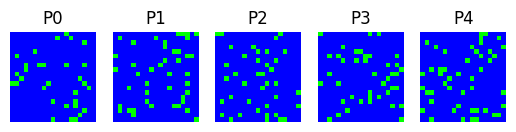

In [ ]:
plot_tools.plot_pattern_list(sigmas_list_as_patterns_sync)
print(sigmas_list_as_patterns_sync)

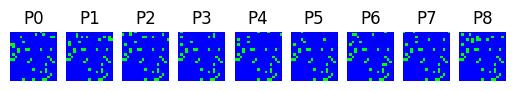

In [ ]:
from helper_functions_ex3 import plot_state_sequence_and_overlap, study_overlap

plot_state_sequence_and_overlap(sigmas_list_as_patterns_sync, pattern_list, overlap_from=cst["N_I"], suptitle="Network dynamics with sync. updates and low activity patterns")

overlap = study_overlap(cst, sigmas_list_as_patterns_sync, pattern_list, overlap_from=cst["N_I"], pattern_init=0)

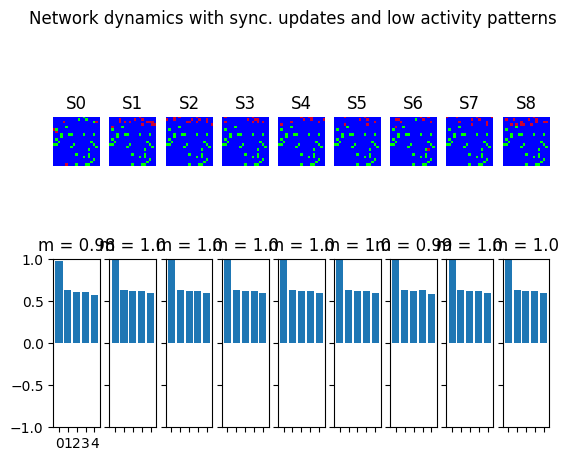

With 8 steps, the network converged to the stored pattern 0.
The overlap is 1.0


In [ ]:
from helper_functions_ex3 import study_overlap, plot_state_sequence_and_overlap

plot_state_sequence_and_overlap(sigmas_list_as_patterns_seq, pattern_list, overlap_from=cst["N_I"], reference_idx=0, suptitle="Network dynamics with seq. updates and low activity patterns")

overlap = study_overlap(cst, sigmas_list_as_patterns_seq, pattern_list, overlap_from=cst["N_I"], pattern_init=0)

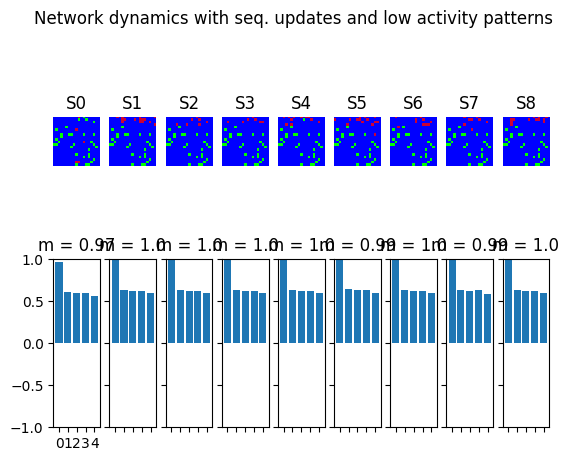

With 8 steps, the network converged to the stored pattern 0.
The overlap is 1.0


## Ex 3.3 Storage capacity study

For different network sizes $N$ from 50 to 800, plot the number of retrieved patterns per dictionary divided by $N$ as a function of the loading $L$.

How does the capacity depend on the network size? Is this what you would expect?

Hint: select a range of $4-5$ loadings $L = \frac{M}{N}$ close to the capacity you found for $N = 300$.

For each network size $N$ and loading $L$, compute the mean and std of the number of retrieved patterns across $5-10$ initialisations of the dictionary to get a plot (with the errorbars).

The capacity corresponds to the average number of retrieved patterns $M_{max}$ that you obtain for an optimal loading $L$, divided by $N$.

In [ ]:
import numpy as np
from helper_functions_ex3 import study_simple_capacity

# Find the capacity for N = 300 as in question 1.6

cst["N"] = 300 + 80
cst["nr_flips"] = int(0.05 * cst["N"])
cst["c_f"] = 0.05                           
cst["T"] = 50
cst["nr_iter"] = 100
M_values = np.arange(5, 25, 1)

capacity = study_simple_capacity(cst, M_values, function_name="sync")

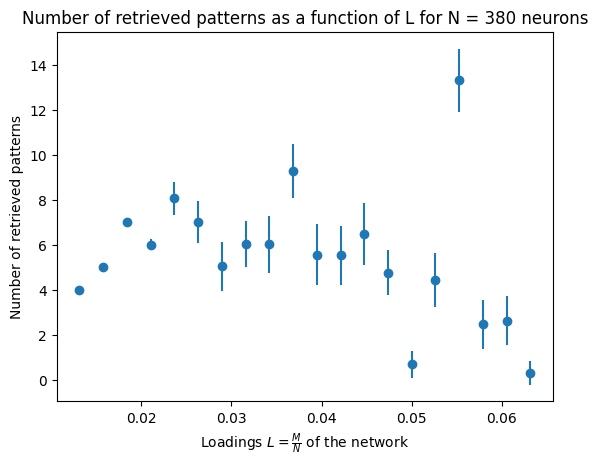

In [ ]:
print(capacity) # Estimation of the capacity from N = 300 neurons, 5% of flipped bits, 50 steps and 100 iterations

0.04473684210526316

In [ ]:
import numpy as np
from helper_functions_ex3 import study_capacity

N_values = np.arange(50, 801, 50)
N_I_values, K_values = [], []
cst["K"] = 60
cst["N"] = 300 + 80
cst["N_I"] = 80

for N in N_values:
    N_I_values.append(int(cst["N_I"]/cst["N"] * N)) # Keep the ratio N_I/N = 80/300 = 4/15 constant.
    K_values.append(int(cst["K"]/cst["N"] * N)) # Keep the ratio K/N constant.

N_values, capacities = study_capacity(cst, N_values, N_I_values, K_values, prev_capacity=capacity, function_name="sync")

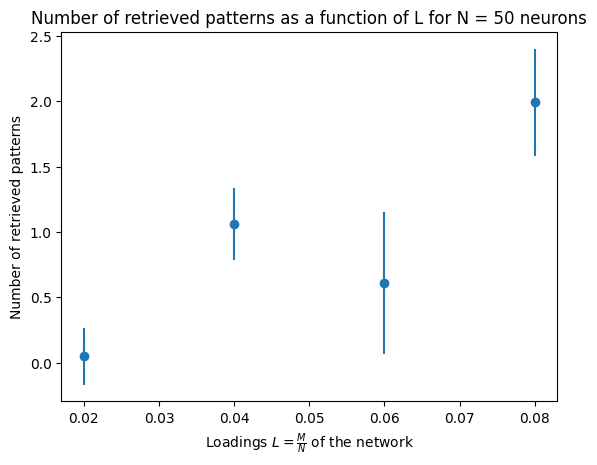

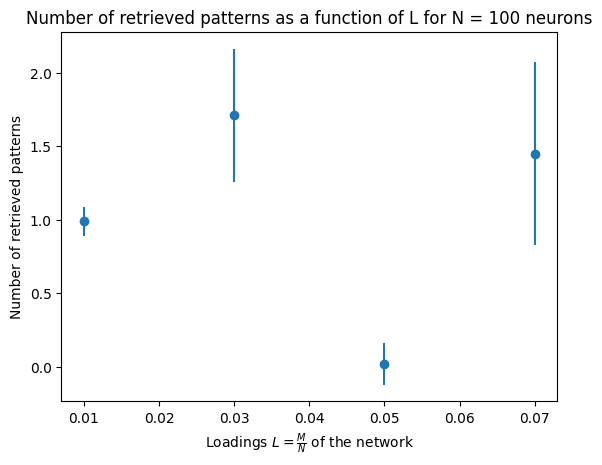

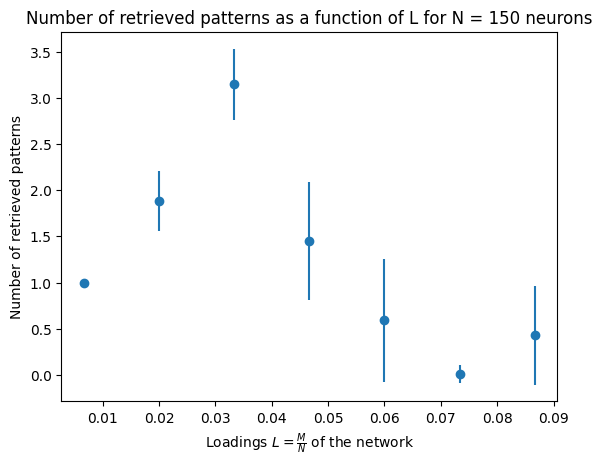

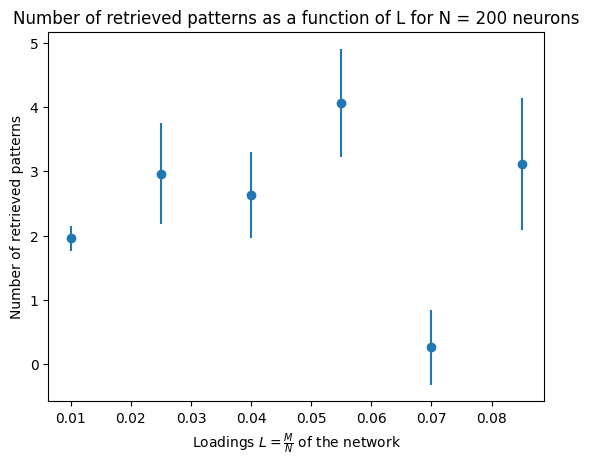

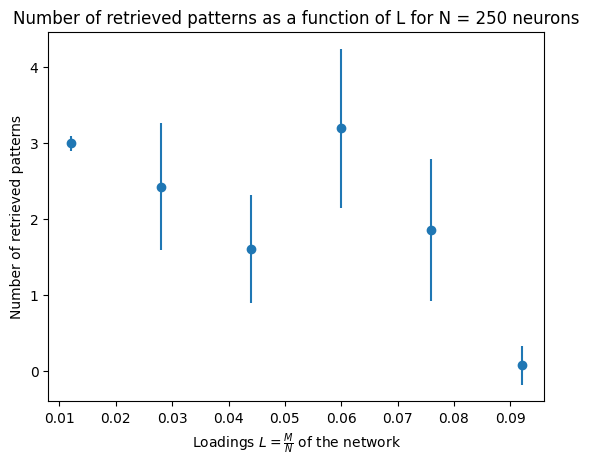

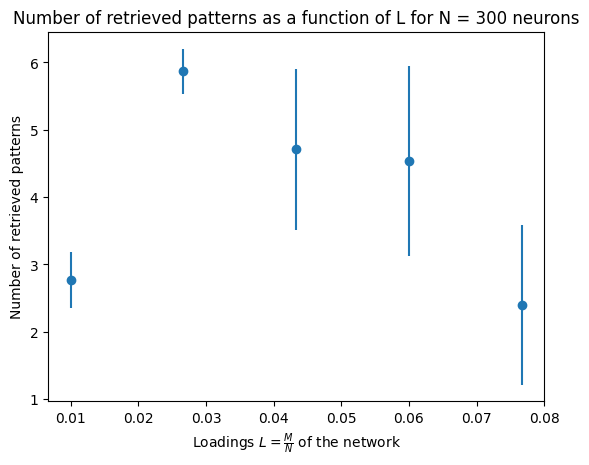

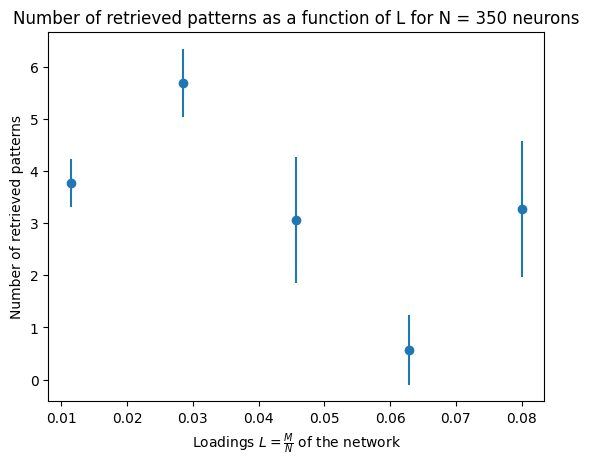

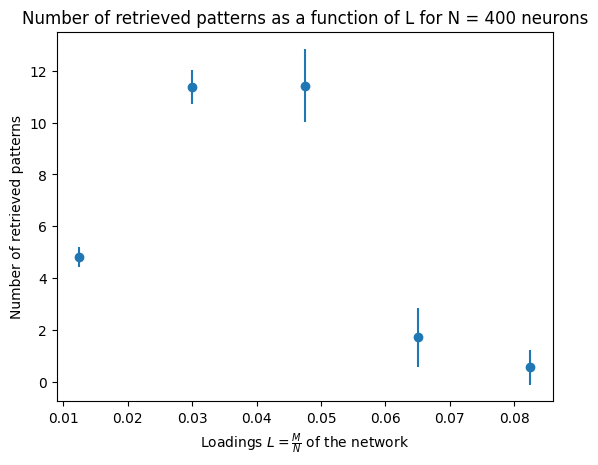

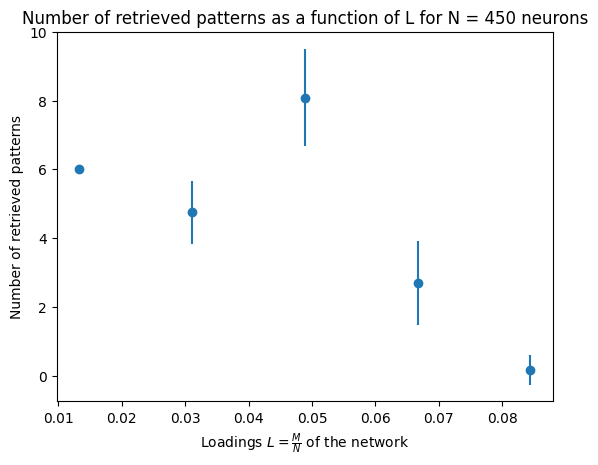

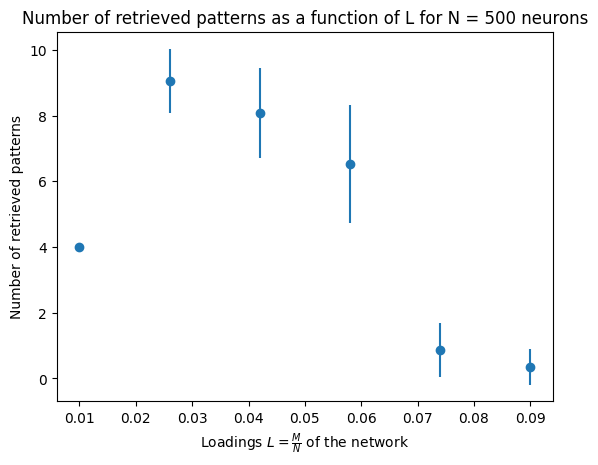

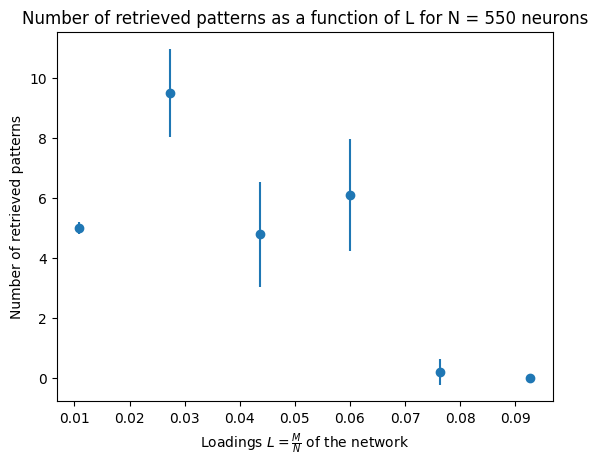

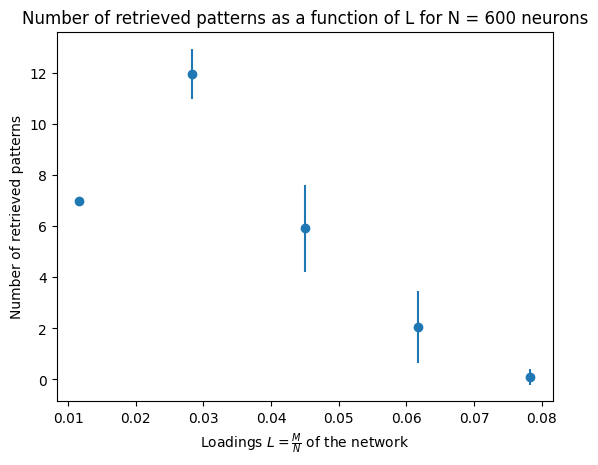

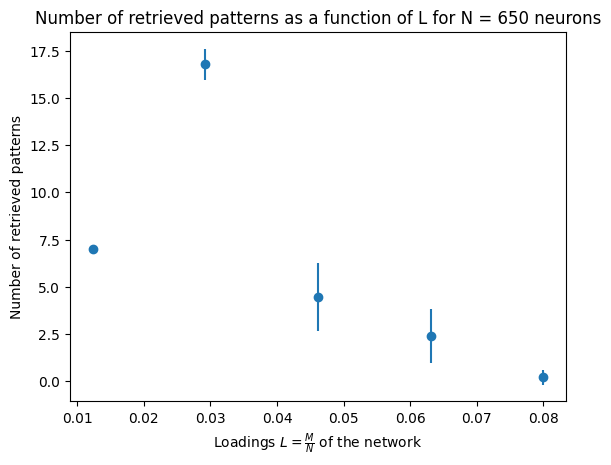

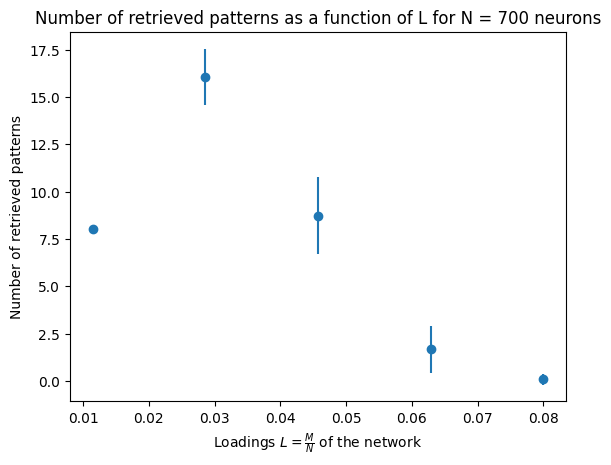

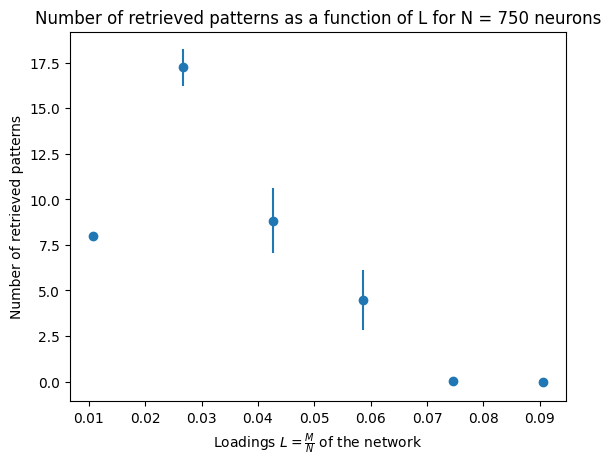

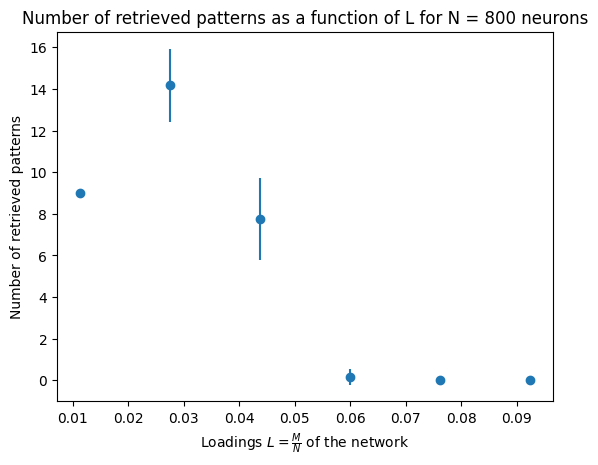

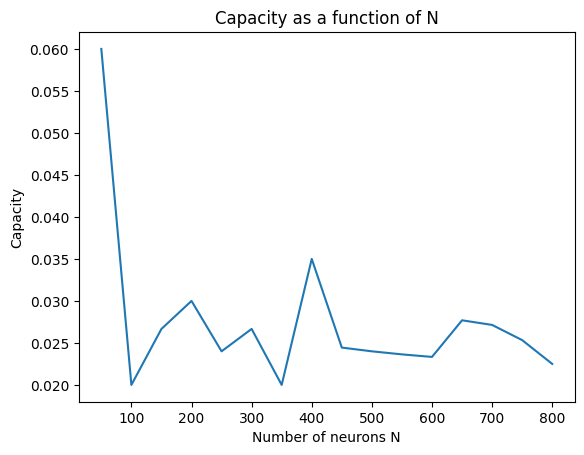

In [ ]:
import numpy as np
from helper_functions_ex3 import study_simple_capacity

# Find the capacity for N = 300 as in question 1.6

cst["N"] = 300 + 80
cst["N_I"] = 80
cst["K"] = 60
cst["nr_flips"] = int(0.05 * cst["N"])
cst["c_f"] = 0.05                           
cst["T"] = 50
cst["nr_iter"] = 100
M_values = np.arange(5, 25, 1)

capacity = study_simple_capacity(cst, M_values, function_name="seq")

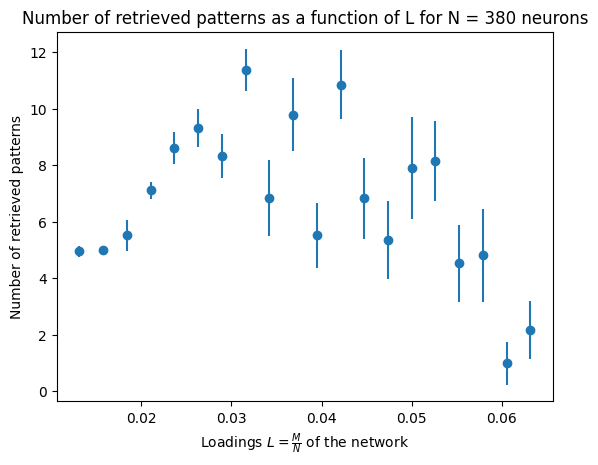

In [ ]:
print(capacity)

0.03684210526315789

In [ ]:
# Same for the sequencial update:
N_values = np.arange(50, 801, 50)
N_I_values, K_values = [], []

for N in N_values:
    N_I_values.append(int(cst["N_I"]/cst["N"] * N)) # Keep the ratio N_I/N = 80/300 = 4/15 constant.
    K_values.append(int(cst["K"]/cst["N"] * N)) # Keep the ratio K/N constant.

N_values, capacities = study_capacity(cst, N_values, N_I_values, K_values, prev_capacity=capacity, function_name="seq")

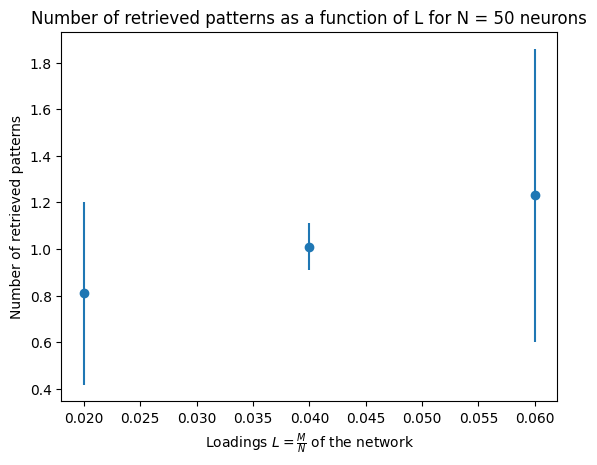

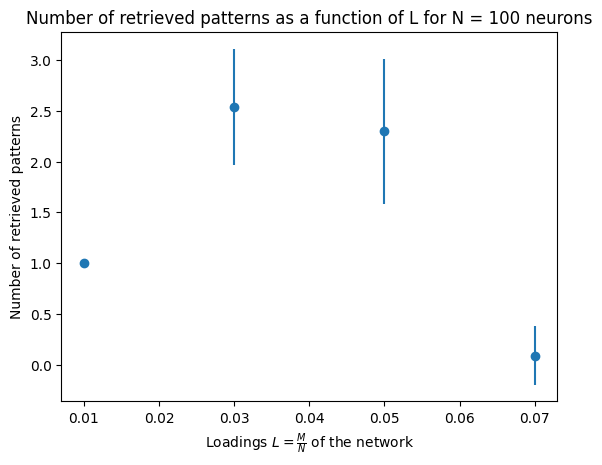

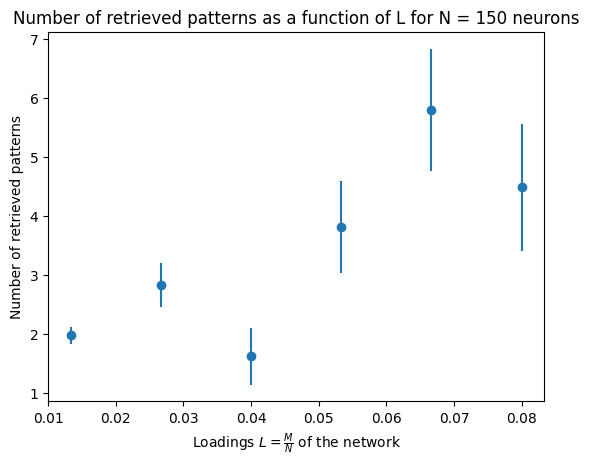

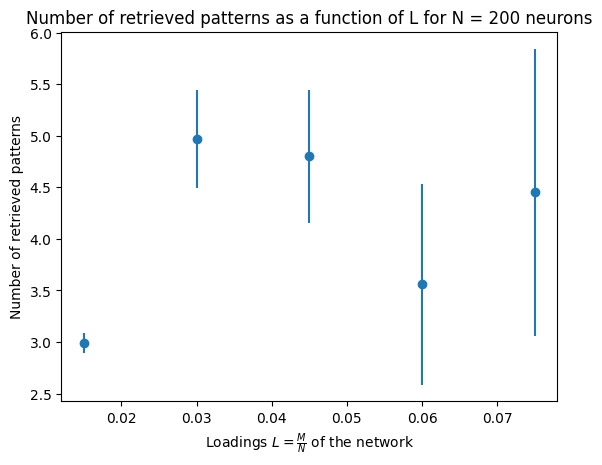

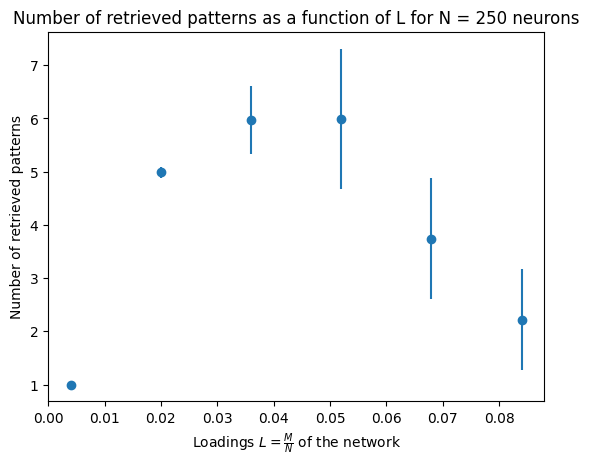

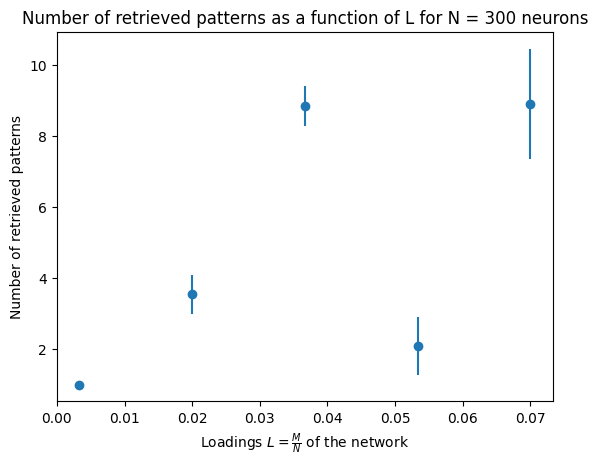

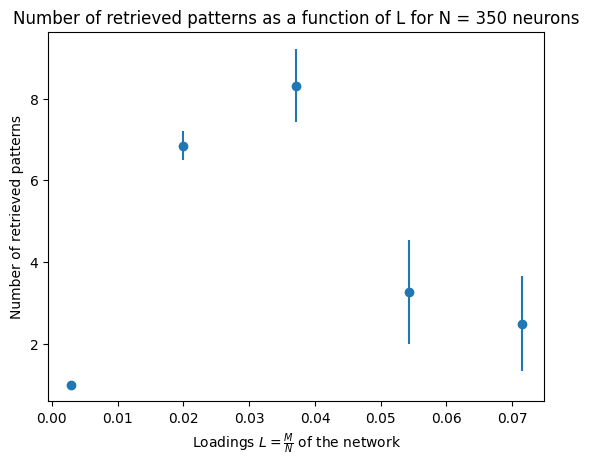

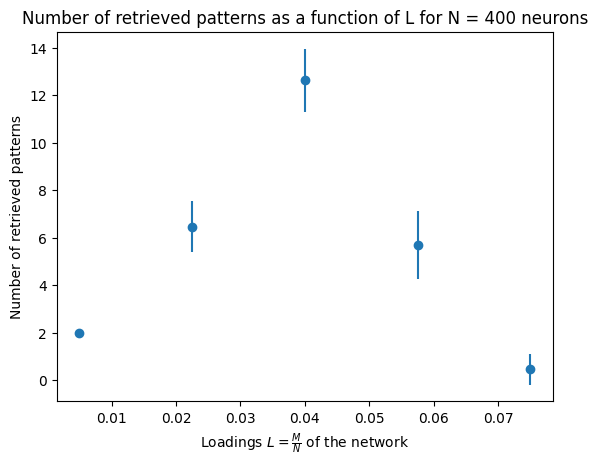

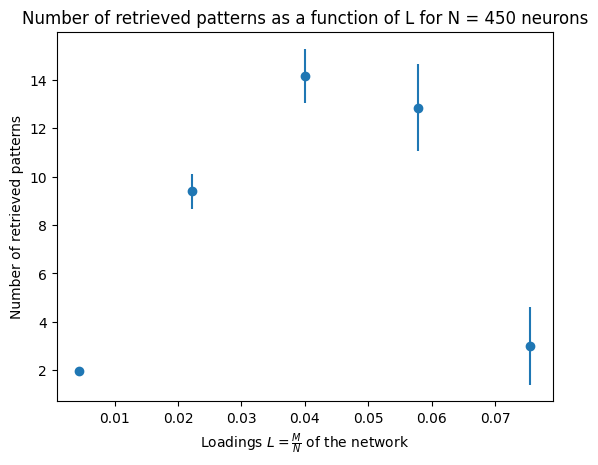

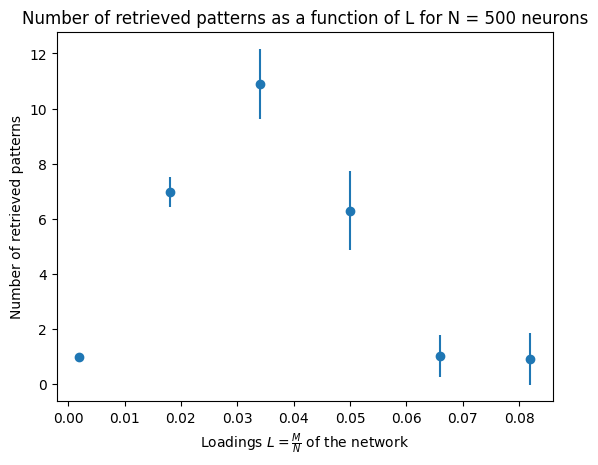

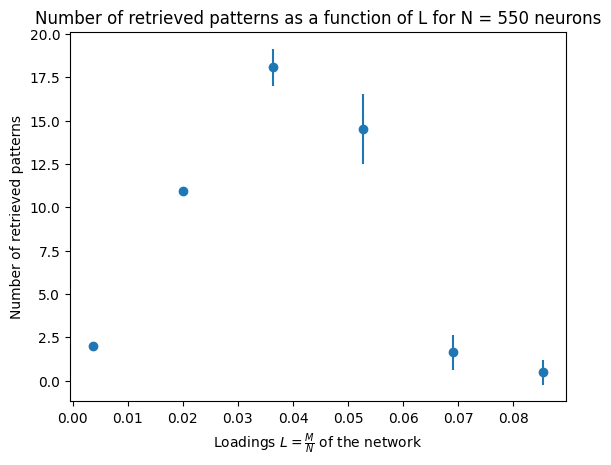

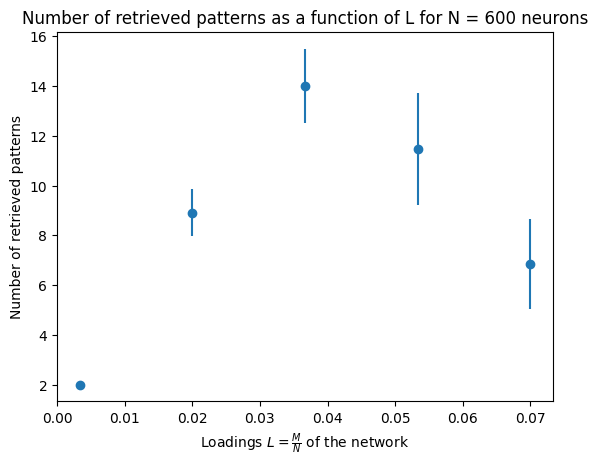

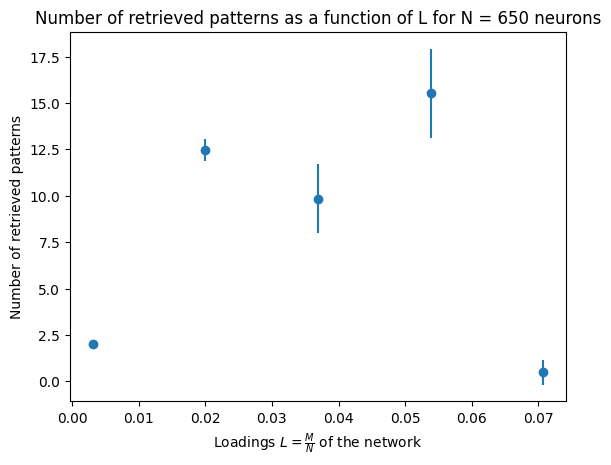

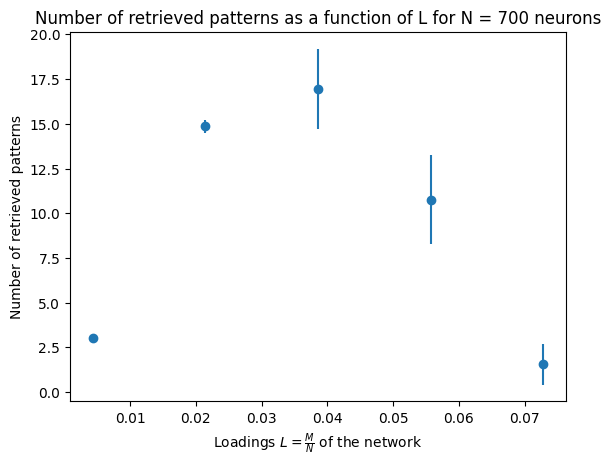

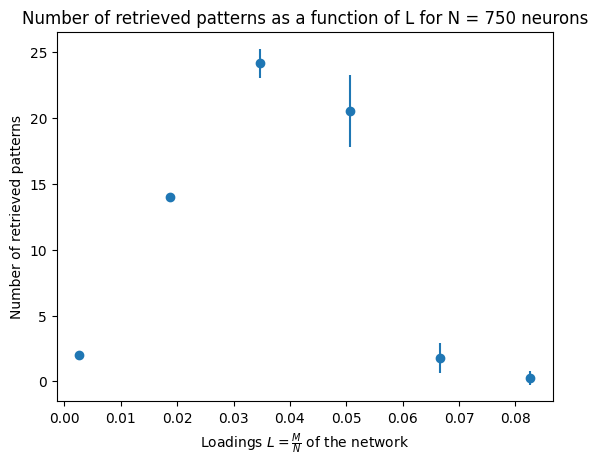

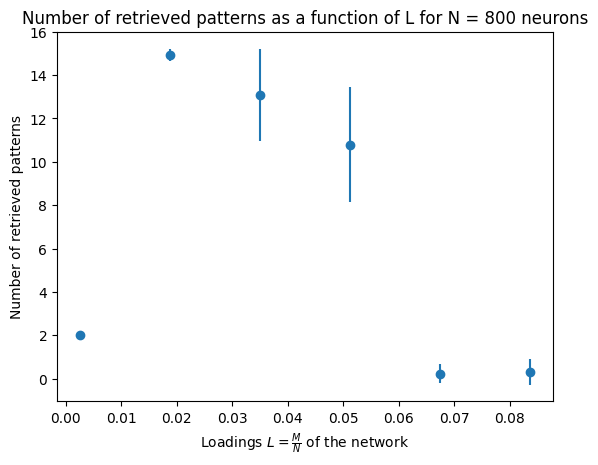

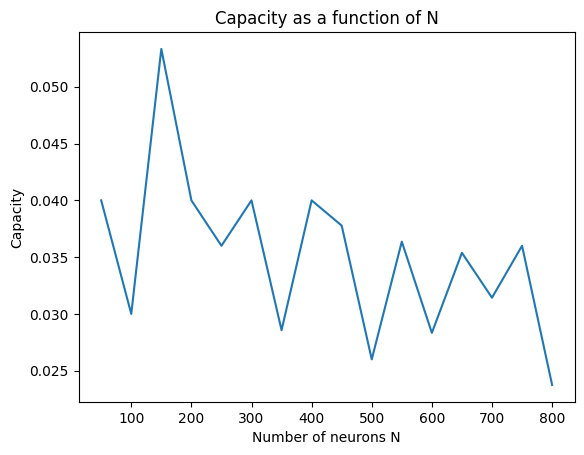

## Ex 3.4

Second inhibitory population. We now add a second inhibitory population of the same size to the network. Neurons of this population can only get activated when the mean activity of the excitatory neurons $\frac{1}{N_E} \sum_i \sigma_i^E$ exceeds $a$; and they project homogeneously to all excitatory neurons with weights $W_{ik}^{E \leftarrow I_2} = \frac{ca}{N_{I_2}}$.

Apart from that, their input weights from excitatory neurons and their activation dynamics have the same properties as the first inhibitory population.

Consider $N_{I_1} = N_{I_2} = N_I$ and $K_1 = K_2 = K$

Repeat question 3.3 with this model. Does the second inhibitory population improve the capacity?
$$
P \{ \sigma_i^{I_2}(t) = 1 | h_k^{I_2}(t), \frac{1}{N_E} \sum_{i=1}^{N_{E}} \sigma_i^{E}(t) > a \} = h_k^{I_2}(t)
$$
$$
h_i^E(t) = \sum_{j=1}^{N_E} W_{ij}^{E \leftarrow E} \sigma_j^E(t) - \sum_{k=1}^{N_I} W_{ik}^{E \leftarrow I_1} \sigma_k^{I_1}(t) - \sum_{k=1}^{N_I} W_{ik}^{E \leftarrow I_2} \sigma_k^{I_2}(t)
$$
$$
h_i^E(t) = -ca \left( \frac{1}{N_I} \sum_{k=1}^{N_I} \sigma_k^{I_2}(t) \right) + \sum_{\mu=1}^M \xi_i^{\mu} \left[ m^{\mu}_{E \leftarrow E} - ca \left( \frac{1}{N_I} \sum_{k=1}^{N_I} \sigma_k^{I_1}(t) \right) \right]
$$
$$
h_k^{I_2}(t) = \sum_{i \in \mathcal{K_2}(k)} W_{ik}^{I_2 \leftarrow E} \sigma_i^E(t) = \sum_{i \in \mathcal{K_2}(k)} \frac{1}{K} \sigma_i^E(t)
$$

To simulate this model, the model will use a population of inhibitory neurons twice bigger $N_I$ and (as weights are not really used in this exercise), only modify the function for one iteration of the model such that the inhibitory population is divided by two ($N_{I_1}$ being the first half and $N_{I_2}$ the second). The equations above are then used, both in a sequential and synced manner.

In [ ]:
# Find the capacity for N = 300 as in question 1.6

cst["N"] = 300 + 80*2
cst["N_I"] = 80 * 2
cst["K"] = 60
cst["nr_flips"] = int(0.05 * cst["N"])
cst["c_f"] = 0.05                           
cst["T"] = 50
cst["nr_iter"] = 15
M_values = np.arange(5, 25, 1)

capacity = study_simple_capacity(cst, M_values, function_name="sync_2inhib")

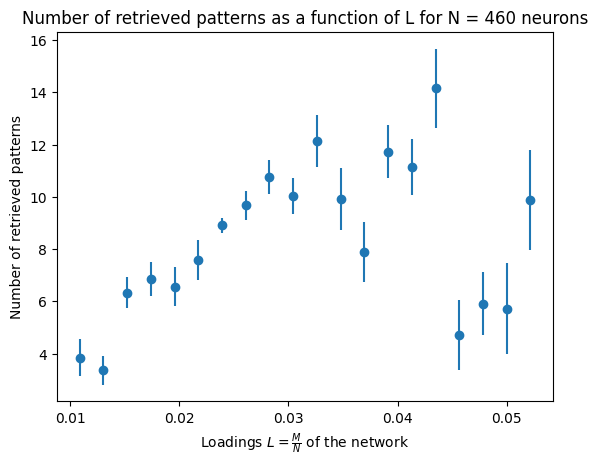

To simulate this model, the model will use a population of inhibitory neurons twice bigger $N_I$ and (as weights are not really used in this exercise), only modify the function for one iteration of the model such that the inhibitory population is divided by two ($N_{I_1}$ being the first half and $N_{I_2}$ the second). The equations above are then used, both in a sequential and synced manner.

In [ ]:
print(capacity)

0.0391304347826087

In [ ]:
N_values = np.arange(50, 801, 50)
cst["N"] = 300 + 80*2
cst["N_I"] = 80 * 2
cst["K"] = 60
cst["nr_iter"] = 15

N_I_values, K_values = [], []

for N in N_values:
    N_I_values.append(int(cst["N_I"]/cst["N"] * N)) # Keep the ratio N_I/N = 80/300 = 4/15 constant.
    K_values.append(int(cst["K"]/cst["N"] * N)) # Keep the ratio K/N constant.

N_values, capacities = study_capacity(cst, N_values, N_I_values, K_values, prev_capacity=capacity, function_name="sync_2inhib")

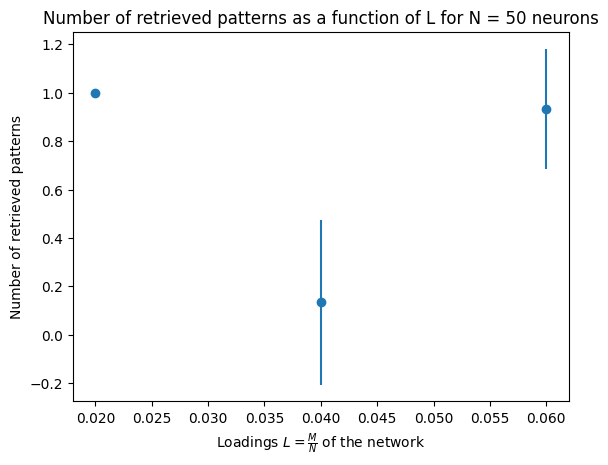

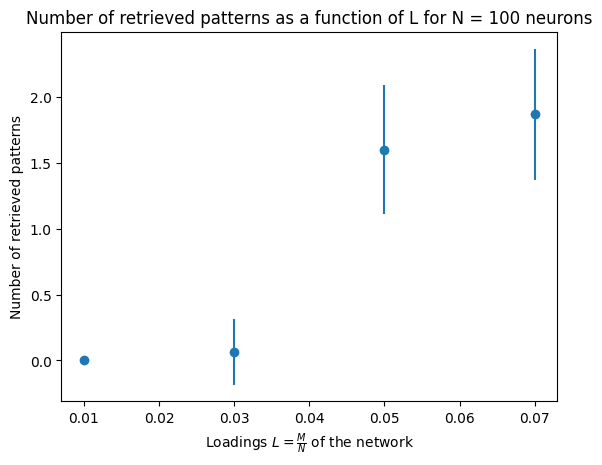

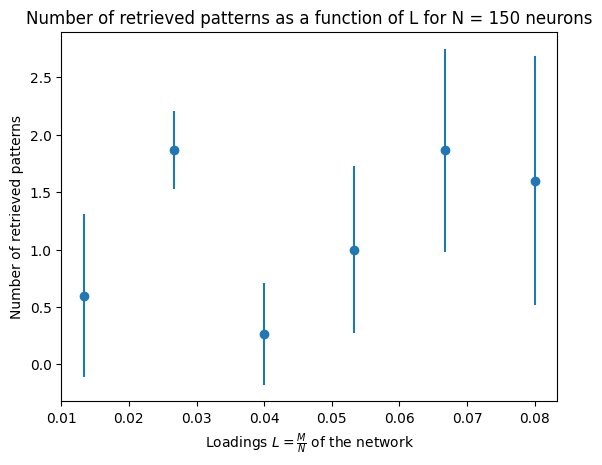

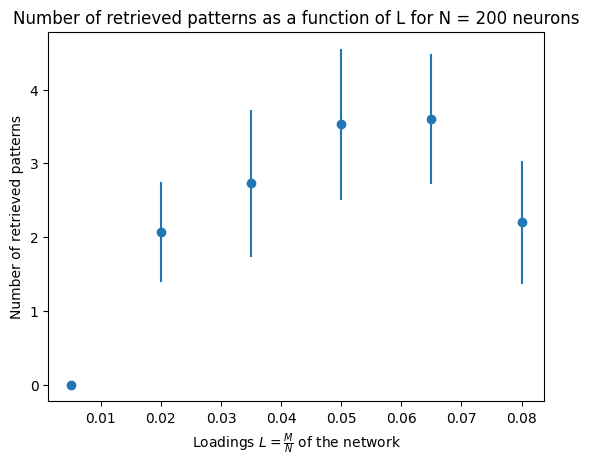

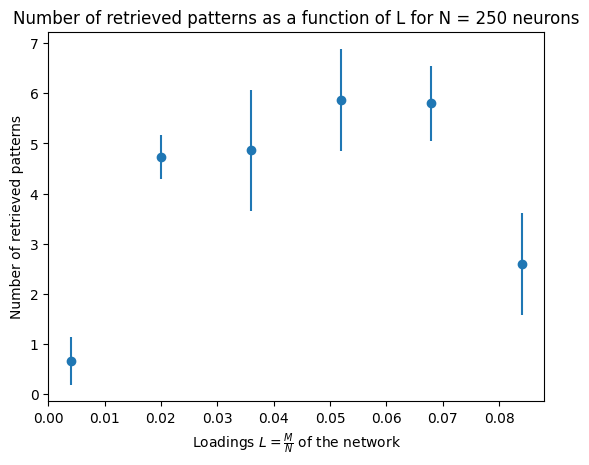

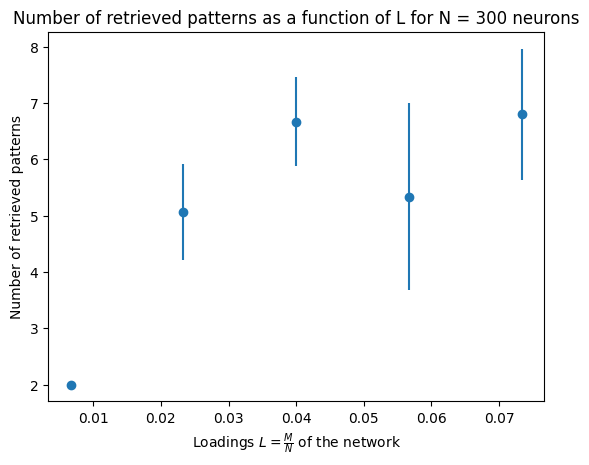

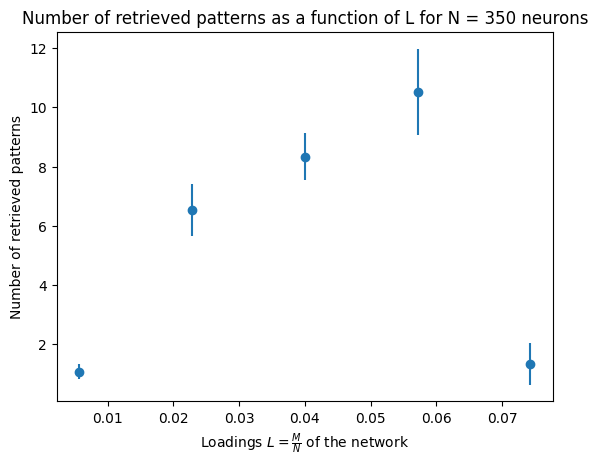

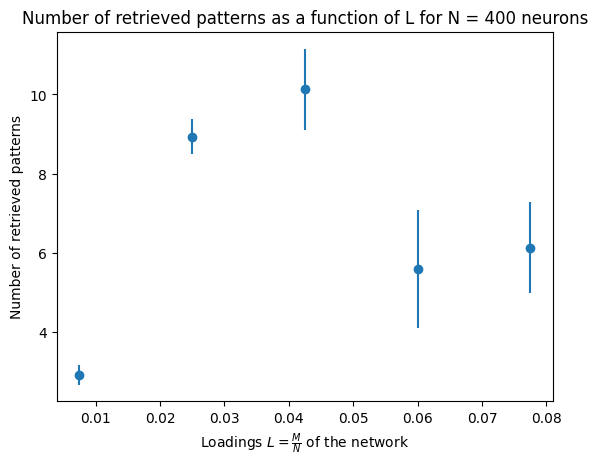

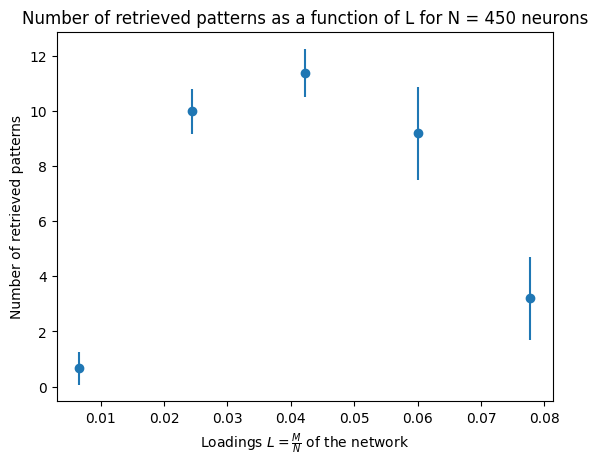

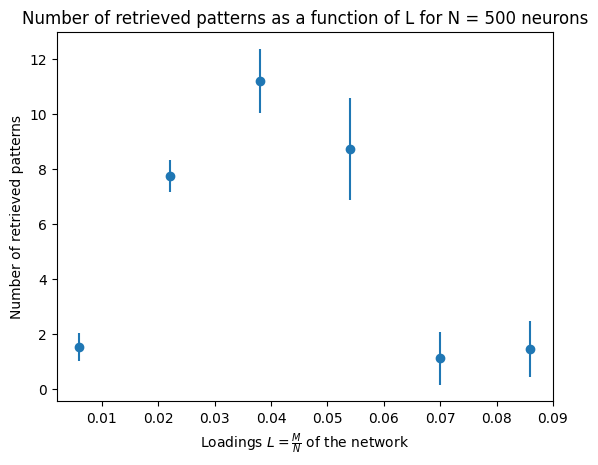

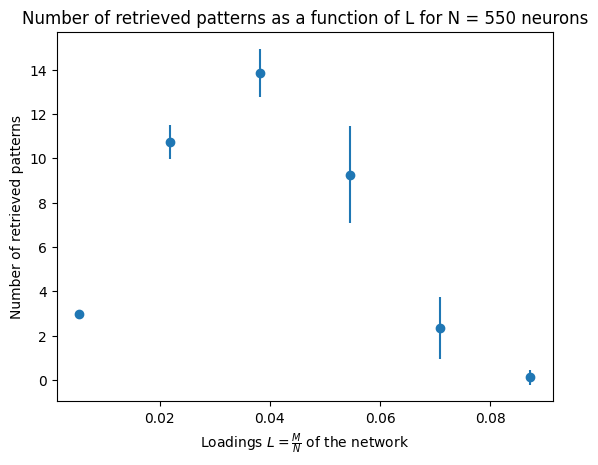

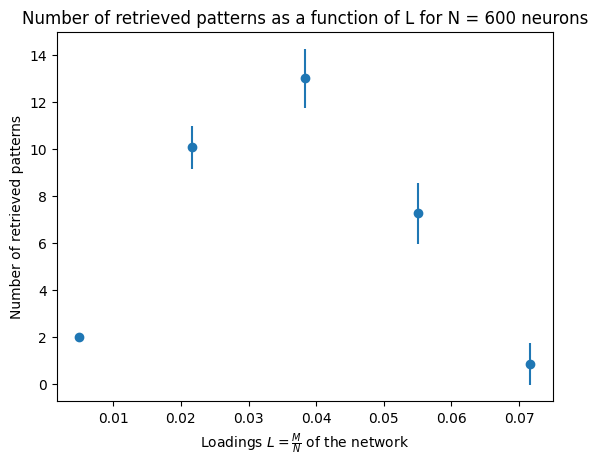

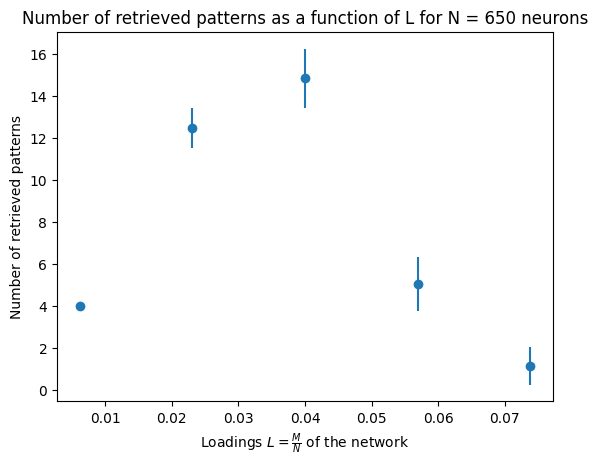

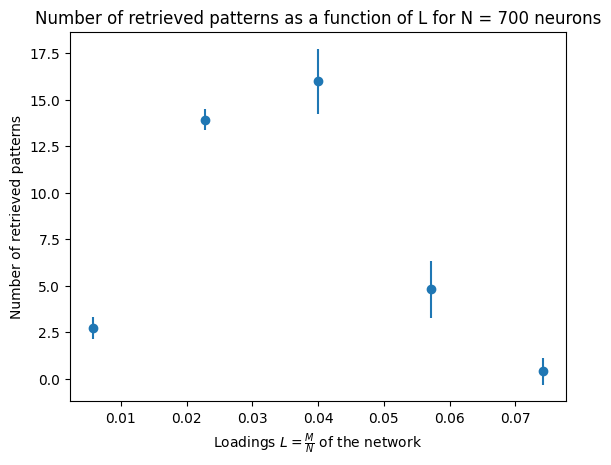

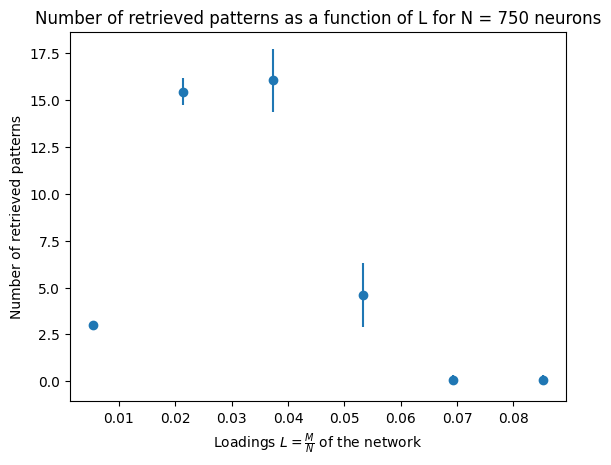

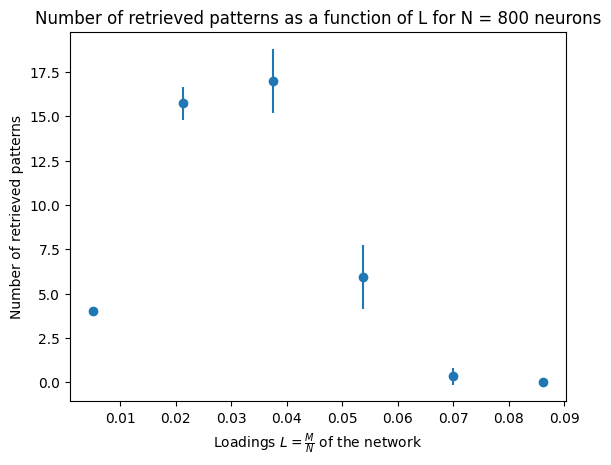

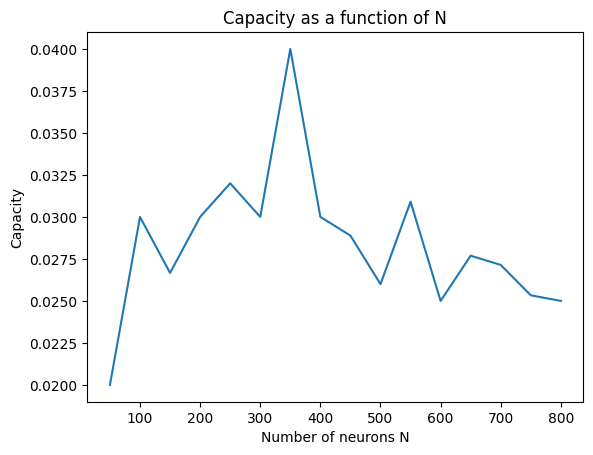

In [ ]:
# Find the capacity for N = 300 as in question 1.6

cst["N"] = 300 + 80*2
cst["N_I"] = 80 * 2
cst["K"] = 60
cst["nr_flips"] = int(0.05 * cst["N"])
cst["c_f"] = 0.05                           
cst["T"] = 50
cst["nr_iter"] = 15
M_values = np.arange(5, 25, 1)

capacity = study_simple_capacity(cst, M_values, function_name="seq_2inhib")

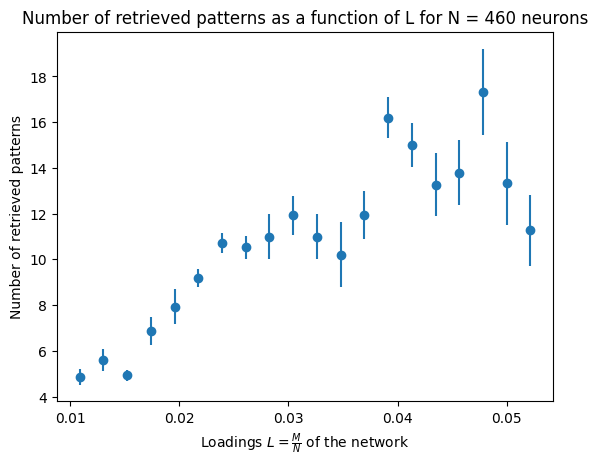

In [ ]:
print(capacity)

0.043478260869565216

In [ ]:
N_values = np.arange(50, 801, 50)
N_I_values, K_values = [], []

for N in N_values:
    N_I_values.append(int(cst["N_I"]/cst["N"] * N)) # Keep the ratio N_I/N = 80/300 = 4/15 constant.
    K_values.append(int(cst["K"]/cst["N"] * N)) # Keep the ratio K/N constant.

N_values, capacities = study_capacity(cst, N_values, N_I_values, K_values, prev_capacity=capacity, function_name="seq_2inhib")

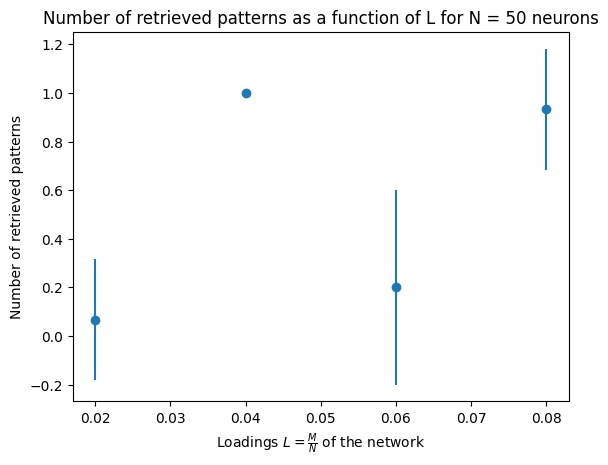

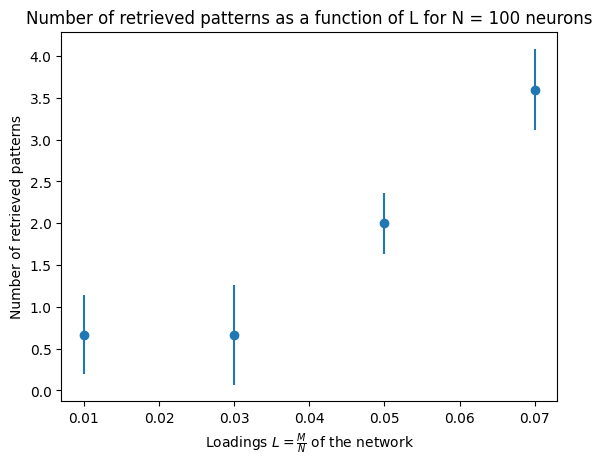

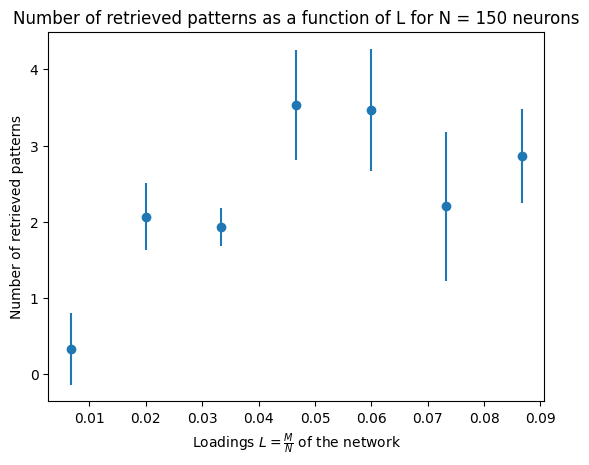

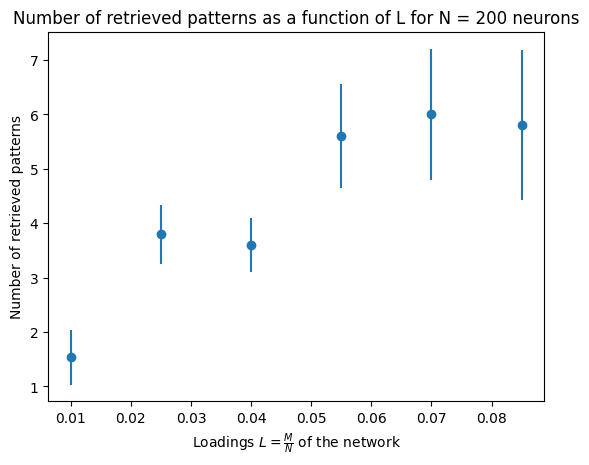

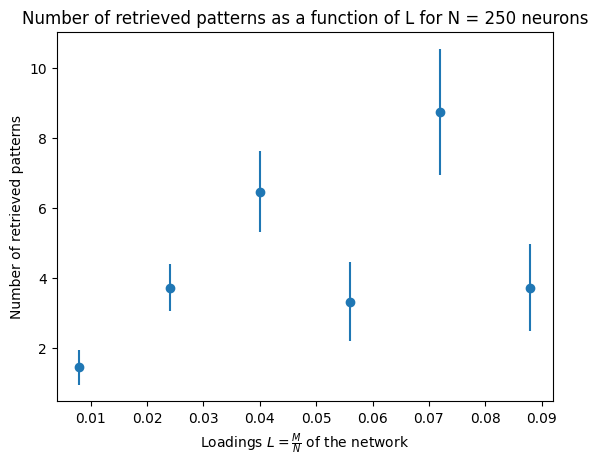

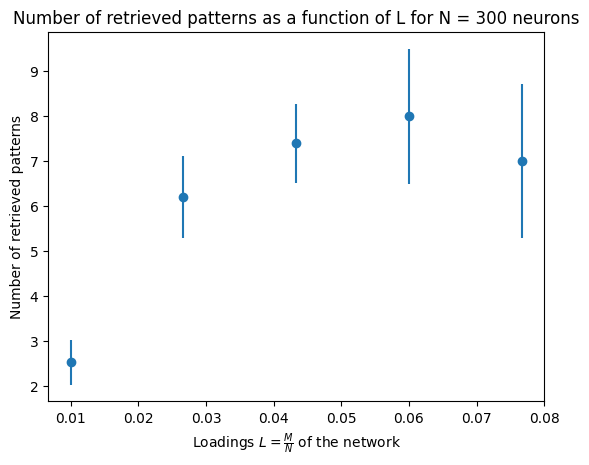

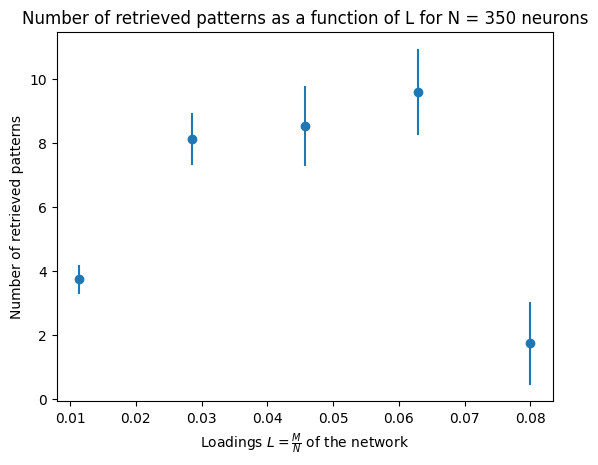

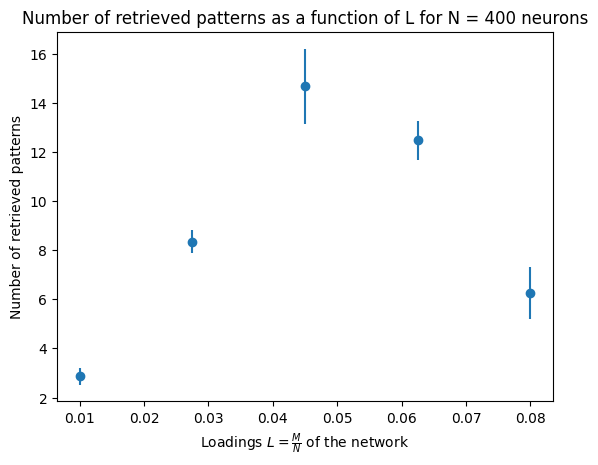

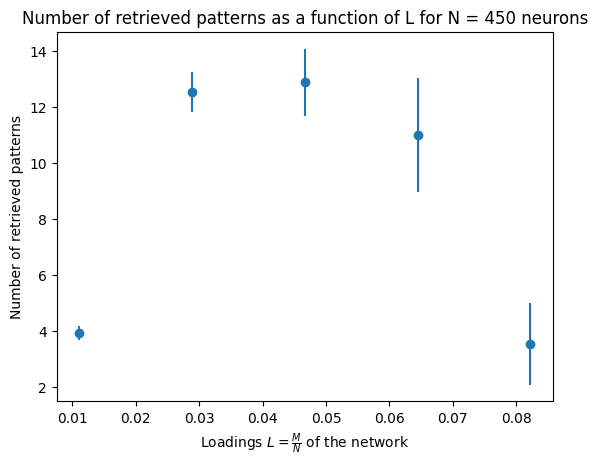

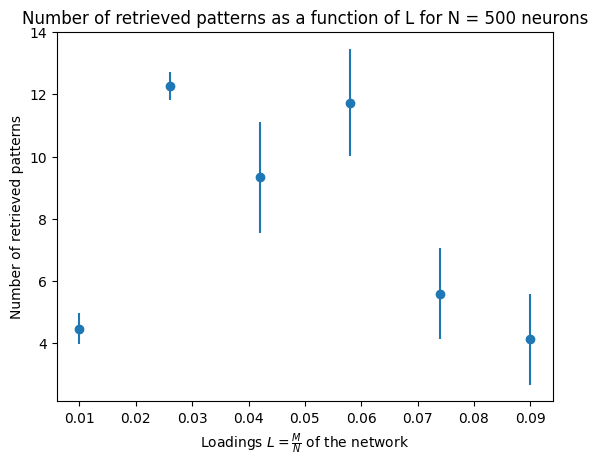

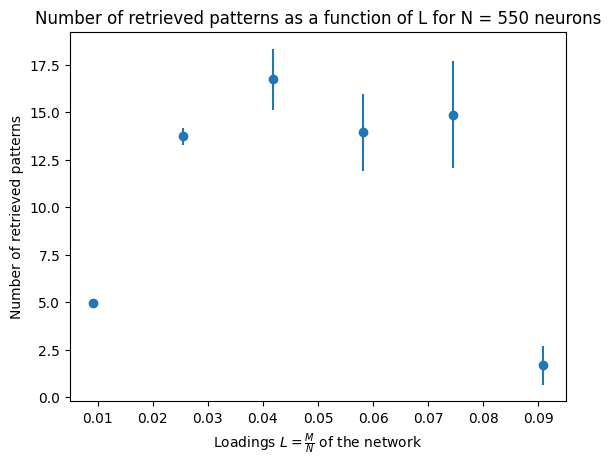

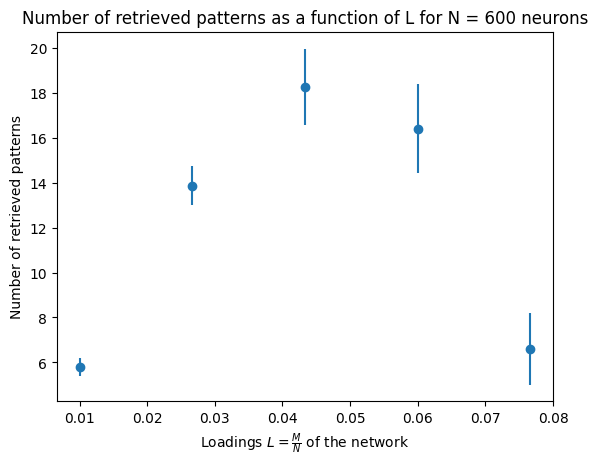

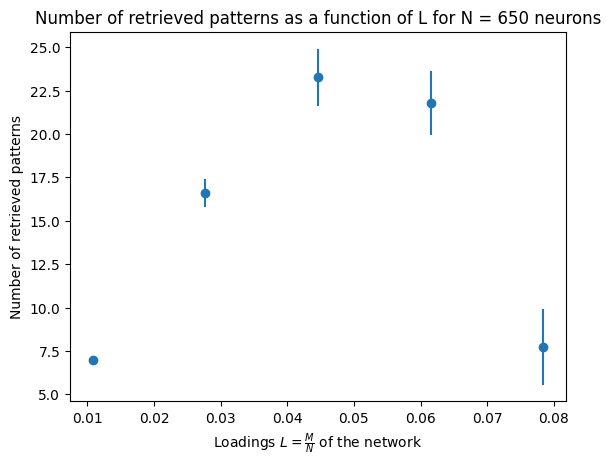

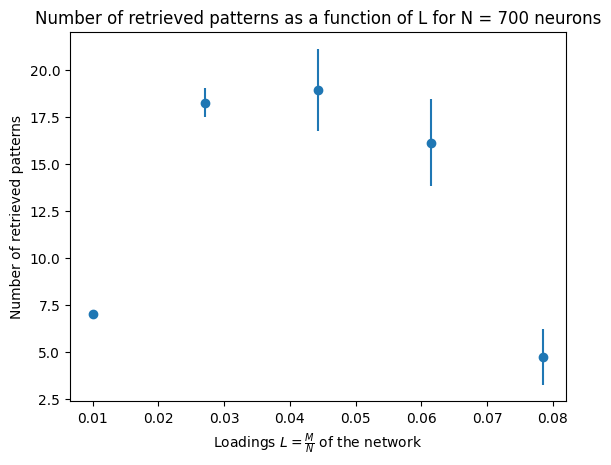

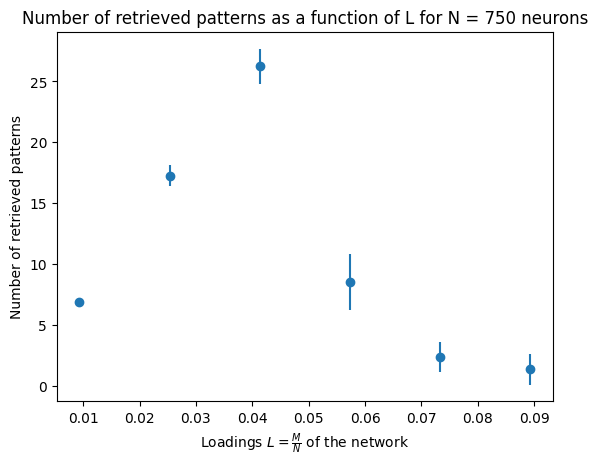

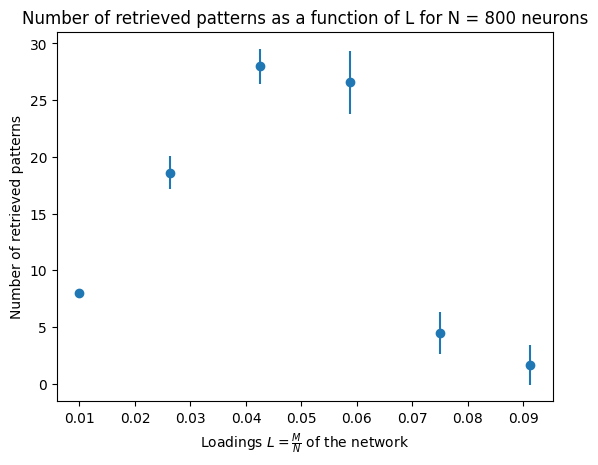

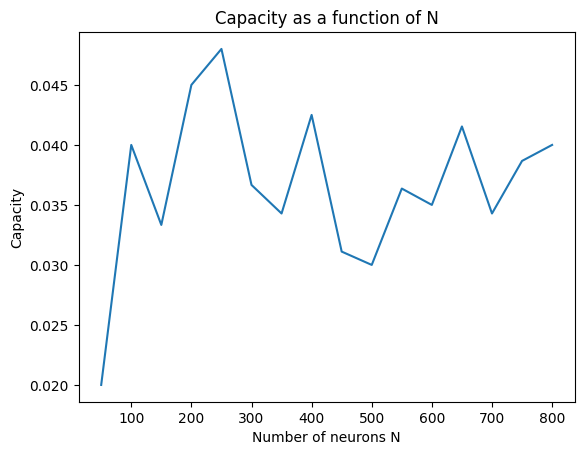

## Ex 3.5

In [ ]:
cst["N"] = 300 + 80 * 2
cst["N_I"] = 80 * 2
cst["K"] = 60
cst["nr_flips"] = int(0.02 * cst["N"])
cst["c_f"] = 0.02                           
cst["M"] = 10

ext_p = {
    "init_steps": 50,
    "feed_steps": 5,
    "evolve_steps": 50,
    "J": 2,
    "sequence_length": 10
}

cst["T"] = ext_p["init_steps"] + (ext_p["feed_steps"] + ext_p["evolve_steps"]) * ext_p["sequence_length"]


In [ ]:
from helper_functions_ex3_states import generate_random_patterns
from neurodynex3.hopfield_network import plot_tools

weights, pattern_list, shape = generate_random_patterns(cst)
plot_tools.plot_pattern_list(pattern_list)

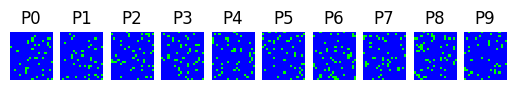

In [ ]:
from helper_functions_ex3 import flip_and_iterate, plot_state_sequence_and_overlap, study_hamming_distances, plot_raster

noisy_init_pattern, sigmas_list, sigmas_list_as_patterns, sigmas_list_ids, full_sigmas_list_as_patterns, patterns_presented = flip_and_iterate(
    cst, shape, pattern_list, init_pattern=0, only_last_state=False, function_name="sync_2inhib", ext_p=ext_p)

plot_raster(cst, full_sigmas_list_as_patterns, separations=[round(cst["N_I"]/2), cst["N_I"]])
study_hamming_distances(cst, full_sigmas_list_as_patterns, pattern_list, overlap_from=cst["N_I"])
print(patterns_presented)

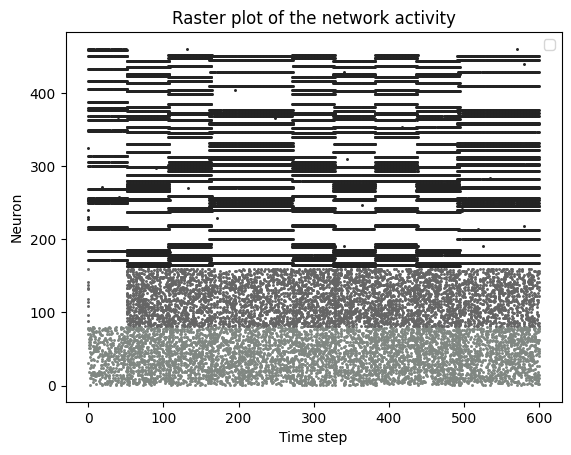

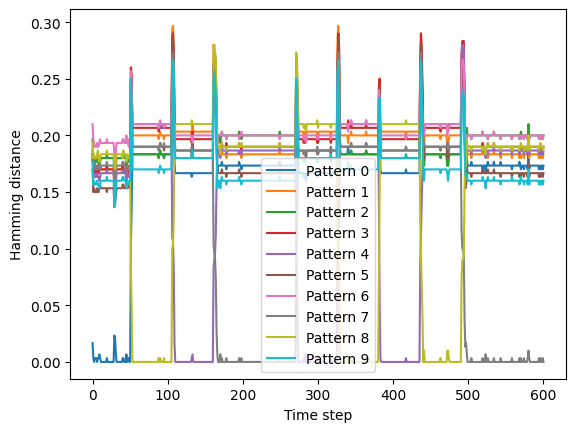

[8, 4, 7, 7, 4, 8, 4, 8, 7, 7]


By plotting the hamming distance against the time, it can be observed that the presented pattern is correctly retrieved after a "hamming distance" spike in less than 5 iterations.

In [ ]:
from helper_functions_ex3 import flip_and_iterate, plot_state_sequence_and_overlap, study_hamming_distances, plot_raster

noisy_init_pattern, sigmas_list, sigmas_list_as_patterns, sigmas_list_ids, full_sigmas_list_as_patterns, patterns_presented = flip_and_iterate(
    cst, shape, pattern_list, init_pattern=0, only_last_state=False, function_name="seq_2inhib", ext_p=ext_p)

plot_raster(cst, full_sigmas_list_as_patterns, separations=[round(cst["N_I"]/2), cst["N_I"]])
study_hamming_distances(cst, full_sigmas_list_as_patterns, pattern_list, overlap_from=cst["N_I"])
print(patterns_presented)

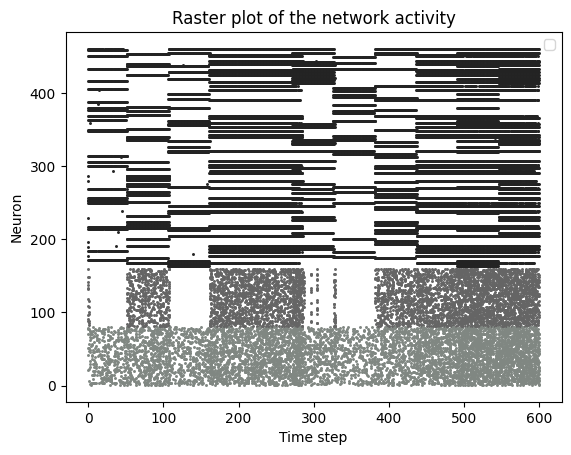

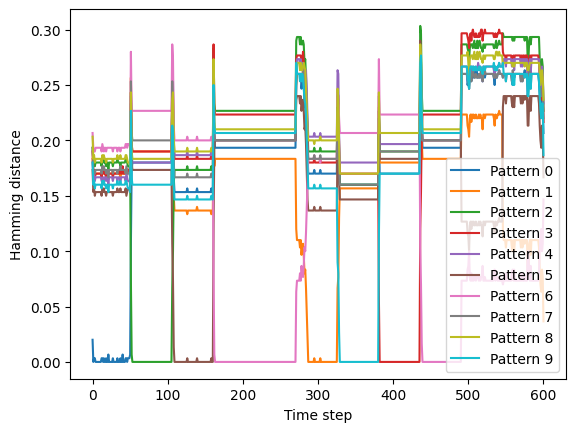

[2, 5, 6, 6, 1, 9, 3, 6, 5, 1]


It makes sense that the pattern has an upper part which is not retrieved (inhibitory neurons) and a bottom part which is retrieved (excitatory neurons).

The hamming distance has some noice at first but as a pattern is presented, the noise strrongly decreases and the presented patterns are much more efficiently retrieved than using a sync. update!